In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced Retinal Vessel Segmentation - Precision Focused
Complete ready-to-run code with all precision improvements
"""

import gdown
!gdown 'https://drive.google.com/uc?id=1tMMamZ6cwoQspo1CoM0pa4faOmaGRNTl' -O DRIVE.zip
!unzip DRIVE.zip -d DRIVE_DATA/
!gdown 'https://drive.google.com/uc?id=18-BWlhI3JP12wYzCNoX9UE1POHflxnLe' -O STARE_DATA.zip
!unzip STARE_DATA.zip -d STARE_DATA/


Downloading...
From (original): https://drive.google.com/uc?id=1tMMamZ6cwoQspo1CoM0pa4faOmaGRNTl
From (redirected): https://drive.google.com/uc?id=1tMMamZ6cwoQspo1CoM0pa4faOmaGRNTl&confirm=t&uuid=3c697caf-0d48-401a-827d-14fcfb6eda22
To: /content/DRIVE.zip
100% 29.3M/29.3M [00:00<00:00, 105MB/s]
Archive:  DRIVE.zip
   creating: DRIVE_DATA/DRIVE/
   creating: DRIVE_DATA/DRIVE/test/
   creating: DRIVE_DATA/DRIVE/test/images/
  inflating: DRIVE_DATA/DRIVE/test/images/01_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/02_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/03_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/04_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/05_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/06_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/07_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/08_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/09_test.tif  
  inflating: DRIVE_DATA/DRIVE/test/images/10_test.tif  
  inflating: D

In [ ]:
# -*- coding: utf-8 -*-
"""
Retinal Vessel Segmentation Training with Model Saving
"""

import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# ==========================================
# DATA TRANSFORMS
# ==========================================
train_transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.ElasticTransform(alpha=0.5, sigma=25, alpha_affine=25, p=0.3),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.GaussNoise(var_limit=(10.0, 20.0), p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
], is_check_shapes=False)

# ==========================================
# DATASET CLASS
# ==========================================
class RetinalVesselDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, debug=False):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.debug = debug

        # Get image files
        self.images = []
        for ext in ['*.tif', '*.png', '*.jpg', '*.jpeg', '*.ppm']:
            self.images.extend(glob.glob(os.path.join(img_dir, ext)))
        self.images = sorted([os.path.basename(f) for f in self.images])

        if self.debug:
            print(f"Found {len(self.images)} images in {img_dir}")

    def __len__(self):
        return len(self.images)

    def is_fov_mask(self, mask):
        """Check if mask is likely a FOV mask (circular boundary)"""
        non_zero_ratio = np.sum(mask > 0) / mask.size

        if 0.5 < non_zero_ratio < 0.9:
            edges = cv2.Canny((mask * 255).astype(np.uint8), 50, 150)
            edge_pixels = np.sum(edges > 0)
            edge_ratio = edge_pixels / np.sum(mask > 0)

            if edge_ratio < 0.02:
                return True
        return False

    def __getitem__(self, idx):
        img_filename = self.images[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        try:
            # Load image
            image = Image.open(img_path).convert("RGB")
            image = np.array(image)

            # Find mask
            base_name = os.path.splitext(img_filename)[0]
            possible_masks = [
                f"{base_name}_manual1.gif",
                f"{base_name}_mask.gif",
                f"{base_name}.gif",
                f"{base_name}_manual1.png",
                f"{base_name}_mask.png",
                f"{base_name}.png"
            ]

            # For DRIVE dataset
            if '_' in base_name:
                img_id = base_name.split('_')[0]
                possible_masks.extend([
                    f"{img_id}_manual1.gif",
                    f"{img_id}_mask.gif"
                ])

            mask_path = None
            if self.mask_dir and os.path.exists(self.mask_dir):
                for mask_name in possible_masks:
                    potential_path = os.path.join(self.mask_dir, mask_name)
                    if os.path.exists(potential_path):
                        mask_path = potential_path
                        break

            # Load mask
            if mask_path and os.path.exists(mask_path):
                mask = Image.open(mask_path).convert("L")
                mask = np.array(mask)

                # Check if this is a FOV mask
                if self.is_fov_mask(mask):
                    if self.debug:
                        print(f"⚠️ Detected FOV mask for {img_filename}, creating empty vessel mask")
                    mask = np.zeros_like(mask, dtype=np.float32)
                else:
                    mask = (mask > 127).astype(np.float32)
            else:
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
                if self.debug:
                    print(f"No vessel mask found for {img_filename}")

            # Apply transforms
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask'].unsqueeze(0)
            else:
                image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
                mask = torch.from_numpy(mask).unsqueeze(0).float()

        except Exception as e:
            print(f"Error loading {img_filename}: {e}")
            image = torch.zeros(3, 512, 512)
            mask = torch.zeros(1, 512, 512)

        return image, mask

def create_dataloaders(img_dir, mask_dir, batch_size=4, val_split=0.2, debug=False):
    """Create train and validation dataloaders"""
    if not os.path.exists(img_dir):
        print(f"Error: Image directory not found - {img_dir}")
        return None, None

    dataset = RetinalVesselDataset(img_dir, mask_dir, transform=train_transform, debug=debug)

    if len(dataset) == 0:
        print("Error: No data found in dataset!")
        return None, None

    val_size = max(1, int(len(dataset) * val_split))
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Set different transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = test_transform

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Dataset created: {len(train_dataset)} train, {len(val_dataset)} val samples")
    return train_loader, val_loader

# ==========================================
# LOSS FUNCTION
# ==========================================
class RecallFocusedLoss(nn.Module):
    """Loss function designed to improve recall for vessel segmentation"""
    def __init__(self, alpha=0.75, gamma=1.5, dice_weight=0.7, recall_weight=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.dice_weight = dice_weight
        self.recall_weight = recall_weight

    def focal_loss(self, pred, target):
        pos_mask = target == 1
        neg_mask = target == 0

        pos_loss = -self.alpha * torch.pow(1 - pred[pos_mask], self.gamma) * torch.log(pred[pos_mask] + 1e-8)
        neg_loss = -(1 - self.alpha) * torch.pow(pred[neg_mask], self.gamma) * torch.log(1 - pred[neg_mask] + 1e-8)

        return (pos_loss.mean() * self.recall_weight + neg_loss.mean()) / (1 + self.recall_weight)

    def dice_loss(self, pred, target):
        smooth = 1e-6
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        return 1 - (2 * intersection + smooth) / (union + smooth)

    def tversky_loss(self, pred, target, alpha=0.3, beta=0.7):
        smooth = 1e-6
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)

        true_pos = (pred_flat * target_flat).sum()
        false_neg = (target_flat * (1 - pred_flat)).sum()
        false_pos = ((1 - target_flat) * pred_flat).sum()

        tversky = (true_pos + smooth) / (true_pos + alpha * false_pos + beta * false_neg + smooth)
        return 1 - tversky

    def forward(self, pred, target):
        focal = self.focal_loss(pred, target)
        dice = self.dice_loss(pred, target)
        tversky = self.tversky_loss(pred, target)

        total_loss = 0.3 * focal + 0.4 * dice + 0.3 * tversky
        return total_loss

# ==========================================
# U-NET MODEL
# ==========================================
class ImprovedUNet(nn.Module):
    """Improved U-Net for vessel segmentation"""
    def __init__(self, in_channels=3, out_channels=1):
        super(ImprovedUNet, self).__init__()

        # Encoder
        self.enc1 = self._make_layer(in_channels, 32)
        self.enc2 = self._make_layer(32, 64)
        self.enc3 = self._make_layer(64, 128)
        self.enc4 = self._make_layer(128, 256)

        # Bottleneck
        self.bottleneck = self._make_layer(256, 512)

        # Decoder
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec4 = self._make_layer(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = self._make_layer(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = self._make_layer(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = self._make_layer(64, 32)

        # Final output
        self.final = nn.Conv2d(32, out_channels, 1)
        self.dropout = nn.Dropout2d(0.1)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))
        b = self.dropout(b)

        # Decoder
        d4 = self.up4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        output = self.final(d1)
        return torch.sigmoid(output)

# ==========================================
# EVALUATION
# ==========================================
def evaluate_model(model, val_loader, device='cuda'):
    """Evaluate model and find optimal threshold"""
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            all_probs.append(outputs.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

    if len(all_probs) == 0:
        return {'precision': 0, 'recall': 0, 'f1_score': 0, 'iou': 0, 'accuracy': 0, 'threshold': 0.5}

    all_probs = np.concatenate(all_probs, axis=0).flatten()
    all_targets = np.concatenate(all_targets, axis=0).flatten()

    if np.sum(all_targets) == 0:
        print("⚠️ No vessel pixels found in validation set")
        return {'precision': 0, 'recall': 0, 'f1_score': 0, 'iou': 0, 'accuracy': 1.0, 'threshold': 0.5}

    # Find optimal threshold
    best_f1 = 0
    best_threshold = 0.5
    best_metrics = {}

    thresholds = np.arange(0.1, 0.9, 0.05)

    for thresh in thresholds:
        preds = (all_probs > thresh).astype(int)

        if np.sum(preds) == 0:
            continue

        precision = precision_score(all_targets, preds, zero_division=0)
        recall = recall_score(all_targets, preds, zero_division=0)
        f1 = f1_score(all_targets, preds, zero_division=0)

        balanced_score = f1 + 0.3 * recall

        if balanced_score > best_f1 and recall > 0.2:
            best_f1 = balanced_score
            best_threshold = thresh
            best_metrics = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'iou': jaccard_score(all_targets, preds, zero_division=0),
                'accuracy': accuracy_score(all_targets, preds),
                'threshold': thresh
            }

    return best_metrics if best_metrics else {
        'precision': 0, 'recall': 0, 'f1_score': 0, 'iou': 0, 'accuracy': 0, 'threshold': 0.5
    }

# ==========================================
# MODEL SAVING FUNCTIONS
# ==========================================
def save_model_checkpoint(model, optimizer, epoch, loss, metrics, save_dir='./saved_models/'):
    """Save model checkpoint with metadata"""
    os.makedirs(save_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'metrics': metrics,
        'timestamp': timestamp,
        'model_architecture': 'ImprovedUNet'
    }

    checkpoint_path = os.path.join(save_dir, f'vessel_model_checkpoint_epoch_{epoch}_{timestamp}.pth')
    torch.save(checkpoint, checkpoint_path)

    size_mb = os.path.getsize(checkpoint_path) / (1024 * 1024)
    print(f"✅ Checkpoint saved: {checkpoint_path} ({size_mb:.2f} MB)")

    return checkpoint_path

def save_best_model(model, save_path='./saved_models/best_vessel_segmentation_model.pth'):
    """Save the best model (complete model)"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save complete model
    torch.save(model, save_path)

    # Also save state dict separately
    state_dict_path = save_path.replace('.pth', '_state_dict.pth')
    torch.save(model.state_dict(), state_dict_path)

    size_mb = os.path.getsize(save_path) / (1024 * 1024)
    print(f"✅ Best model saved: {save_path} ({size_mb:.2f} MB)")
    print(f"✅ State dict saved: {state_dict_path}")

    return save_path

def load_model(model_path, device='cuda'):
    """Load a saved model"""
    if model_path.endswith('_state_dict.pth'):
        # Load state dict
        model = ImprovedUNet(in_channels=3, out_channels=1).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
    else:
        # Load complete model
        model = torch.load(model_path, map_location=device)

    model.eval()
    print(f"✅ Model loaded from: {model_path}")
    return model

# ==========================================
# TRAINING FUNCTION
# ==========================================
def train_model(model, train_loader, val_loader, epochs=50, device='cuda', lr=1e-3):
    """Train the segmentation model"""
    criterion = RecallFocusedLoss(alpha=0.75, gamma=1.5, dice_weight=0.7, recall_weight=2.0)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    best_f1 = 0.0
    best_recall = 0.0
    train_losses = []
    val_metrics = []

    print("🚀 Starting training...")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_steps = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()
            train_steps += 1

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_train_loss = train_loss / train_steps
        train_losses.append(avg_train_loss)

        # Validation phase
        if val_loader:
            val_metrics_epoch = evaluate_model(model, val_loader, device)
            val_metrics.append(val_metrics_epoch)

            scheduler.step()

            # Save checkpoints
            current_f1 = val_metrics_epoch.get('f1_score', 0)
            current_recall = val_metrics_epoch.get('recall', 0)

            # Save checkpoint every 10 epochs
            if (epoch + 1) % 10 == 0:
                save_model_checkpoint(model, optimizer, epoch + 1, avg_train_loss, val_metrics_epoch)

            # Save best model
            save_best = False
            if current_recall > 0.5 and current_f1 > best_f1:
                best_f1 = current_f1
                save_best = True
                print(f"✅ New best F1 model! F1: {current_f1:.4f}, Recall: {current_recall:.4f}")
            elif current_recall > best_recall and current_recall > 0.3:
                best_recall = current_recall
                save_best = True
                print(f"✅ New best recall model! Recall: {current_recall:.4f}, F1: {current_f1:.4f}")

            if save_best:
                save_best_model(model)

            # Print metrics
            print(f"Epoch {epoch+1}: Loss={avg_train_loss:.4f}, "
                  f"Precision={val_metrics_epoch.get('precision', 0):.4f}, "
                  f"Recall={val_metrics_epoch.get('recall', 0):.4f}, "
                  f"F1={val_metrics_epoch.get('f1_score', 0):.4f}")
        else:
            scheduler.step()
            print(f"Epoch {epoch+1}: Loss={avg_train_loss:.4f}")

    # Save final model
    final_model_path = save_best_model(model, './saved_models/final_vessel_segmentation_model.pth')

    # Save final checkpoint
    final_checkpoint = save_model_checkpoint(
        model, optimizer, epochs, avg_train_loss,
        val_metrics[-1] if val_metrics else {},
        save_dir='./saved_models/'
    )

    print(f"\n🎉 Training completed!")
    print(f"📁 Final model saved at: {final_model_path}")
    print(f"📁 Final checkpoint saved at: {final_checkpoint}")

    return train_losses, val_metrics

# ==========================================
# MAIN FUNCTION
# ==========================================
def main():
    print("🚀 Starting Retinal Vessel Segmentation Training")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define paths - UPDATE these as per your data structure
    base_dir = '/content/DRIVE_DATA/DRIVE'  # <-- Change if needed
    train_img_dir = os.path.join(base_dir, 'train/images')
    train_mask_dir = os.path.join(base_dir, 'train/labels')

    # Check directories
    if not os.path.exists(base_dir):
        print(f"❌ Base directory not found: {base_dir}")
        print("Please update the base_dir path in the main() function")
        return

    # Create data loaders
    print("\n📊 Creating data loaders...")
    train_loader, val_loader = create_dataloaders(
        train_img_dir, train_mask_dir, batch_size=2, debug=True
    )

    if train_loader is None:
        print("❌ Failed to create training data loaders.")
        return

    # Initialize model
    print("\n🧠 Initializing model...")
    model = ImprovedUNet(in_channels=3, out_channels=1).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model
    print("\n🎯 Starting training...")
    train_losses, val_metrics = train_model(
        model, train_loader, val_loader, epochs=30, device=device, lr=1e-3
    )

    print("\n✅ Training completed! Model saved successfully!")
    print("📁 Check the './saved_models/' directory for your trained models")

if __name__ == "__main__":
    main()

<ipython-input-3-26a0e507d38a>:34: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=0.5, sigma=25, alpha_affine=25, p=0.3),
<ipython-input-3-26a0e507d38a>:37: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 20.0), p=0.3),


🚀 Starting Retinal Vessel Segmentation Training
Using device: cuda

📊 Creating data loaders...
Found 20 images in /content/DRIVE_DATA/DRIVE/train/images
Dataset created: 16 train, 4 val samples

🧠 Initializing model...
Model parameters: 7,763,041

🎯 Starting training...
🚀 Starting training...


Epoch 1/30: 100%|██████████| 8/8 [00:04<00:00,  1.86it/s, loss=0.5555]


✅ New best F1 model! F1: 0.2362, Recall: 0.9883
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 1: Loss=0.6186, Precision=0.1342, Recall=0.9883, F1=0.2362


Epoch 2/30: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s, loss=0.5289]


✅ New best recall model! Recall: 0.9986, F1: 0.1761
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 2: Loss=0.5065, Precision=0.0965, Recall=0.9986, F1=0.1761


Epoch 3/30: 100%|██████████| 8/8 [00:01<00:00,  4.38it/s, loss=0.4012]


✅ New best F1 model! F1: 0.2561, Recall: 0.8824
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 3: Loss=0.4455, Precision=0.1498, Recall=0.8824, F1=0.2561


Epoch 4/30: 100%|██████████| 8/8 [00:01<00:00,  4.95it/s, loss=0.4465]


✅ New best F1 model! F1: 0.3195, Recall: 0.8709
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 4: Loss=0.4243, Precision=0.1956, Recall=0.8709, F1=0.3195


Epoch 5/30: 100%|██████████| 8/8 [00:01<00:00,  4.87it/s, loss=0.3779]


✅ New best F1 model! F1: 0.4572, Recall: 0.7188
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 5: Loss=0.3860, Precision=0.3352, Recall=0.7188, F1=0.4572


Epoch 6/30: 100%|██████████| 8/8 [00:01<00:00,  4.91it/s, loss=0.3048]


✅ New best F1 model! F1: 0.6609, Recall: 0.7436
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 6: Loss=0.3533, Precision=0.5948, Recall=0.7436, F1=0.6609


Epoch 7/30: 100%|██████████| 8/8 [00:01<00:00,  4.77it/s, loss=0.3036]


✅ New best F1 model! F1: 0.7021, Recall: 0.7749
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 7: Loss=0.3292, Precision=0.6418, Recall=0.7749, F1=0.7021


Epoch 8/30: 100%|██████████| 8/8 [00:01<00:00,  4.99it/s, loss=0.2823]


Epoch 8: Loss=0.3243, Precision=0.5862, Recall=0.7977, F1=0.6758


Epoch 9/30: 100%|██████████| 8/8 [00:01<00:00,  4.92it/s, loss=0.2839]


Epoch 9: Loss=0.3131, Precision=0.5999, Recall=0.7945, F1=0.6836


Epoch 10/30: 100%|██████████| 8/8 [00:01<00:00,  4.95it/s, loss=0.3014]


✅ Checkpoint saved: ./saved_models/vessel_model_checkpoint_epoch_10_20250526_133526.pth (88.96 MB)
Epoch 10: Loss=0.3074, Precision=0.6158, Recall=0.7876, F1=0.6912


Epoch 11/30: 100%|██████████| 8/8 [00:01<00:00,  4.57it/s, loss=0.3276]


Epoch 11: Loss=0.3269, Precision=0.2885, Recall=0.8851, F1=0.4352


Epoch 12/30: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s, loss=0.3032]


Epoch 12: Loss=0.3361, Precision=0.3311, Recall=0.8603, F1=0.4782


Epoch 13/30: 100%|██████████| 8/8 [00:01<00:00,  4.86it/s, loss=0.3043]


Epoch 13: Loss=0.3089, Precision=0.6132, Recall=0.8001, F1=0.6943


Epoch 14/30: 100%|██████████| 8/8 [00:01<00:00,  4.81it/s, loss=0.2819]


Epoch 14: Loss=0.2964, Precision=0.5558, Recall=0.8030, F1=0.6569


Epoch 15/30: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s, loss=0.2842]


Epoch 15: Loss=0.3123, Precision=0.3823, Recall=0.8438, F1=0.5262


Epoch 16/30: 100%|██████████| 8/8 [00:01<00:00,  4.61it/s, loss=0.2708]


Epoch 16: Loss=0.2851, Precision=0.5397, Recall=0.8138, F1=0.6490


Epoch 17/30: 100%|██████████| 8/8 [00:01<00:00,  4.96it/s, loss=0.2583]


✅ New best F1 model! F1: 0.7363, Recall: 0.7961
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 17: Loss=0.2849, Precision=0.6848, Recall=0.7961, F1=0.7363


Epoch 18/30: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s, loss=0.2559]


✅ New best F1 model! F1: 0.7500, Recall: 0.8092
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 18: Loss=0.2811, Precision=0.6988, Recall=0.8092, F1=0.7500


Epoch 19/30: 100%|██████████| 8/8 [00:01<00:00,  4.75it/s, loss=0.2449]


✅ New best F1 model! F1: 0.7606, Recall: 0.8099
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 19: Loss=0.2749, Precision=0.7169, Recall=0.8099, F1=0.7606


Epoch 20/30: 100%|██████████| 8/8 [00:01<00:00,  4.23it/s, loss=0.2552]


✅ Checkpoint saved: ./saved_models/vessel_model_checkpoint_epoch_20_20250526_133626.pth (88.96 MB)
Epoch 20: Loss=0.2615, Precision=0.7077, Recall=0.8203, F1=0.7598


Epoch 21/30: 100%|██████████| 8/8 [00:01<00:00,  4.84it/s, loss=0.2835]


Epoch 21: Loss=0.2737, Precision=0.6544, Recall=0.8339, F1=0.7333


Epoch 22/30: 100%|██████████| 8/8 [00:01<00:00,  4.48it/s, loss=0.2540]


Epoch 22: Loss=0.2577, Precision=0.6518, Recall=0.8287, F1=0.7297


Epoch 23/30: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s, loss=0.2240]


Epoch 23: Loss=0.2526, Precision=0.6722, Recall=0.8321, F1=0.7436


Epoch 24/30: 100%|██████████| 8/8 [00:01<00:00,  4.85it/s, loss=0.2503]


Epoch 24: Loss=0.2501, Precision=0.6973, Recall=0.8305, F1=0.7581


Epoch 25/30: 100%|██████████| 8/8 [00:01<00:00,  4.78it/s, loss=0.2178]


✅ New best F1 model! F1: 0.7667, Recall: 0.8246
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 25: Loss=0.2484, Precision=0.7165, Recall=0.8246, F1=0.7667


Epoch 26/30: 100%|██████████| 8/8 [00:01<00:00,  4.67it/s, loss=0.2181]


✅ New best F1 model! F1: 0.7670, Recall: 0.8299
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 26: Loss=0.2434, Precision=0.7129, Recall=0.8299, F1=0.7670


Epoch 27/30: 100%|██████████| 8/8 [00:01<00:00,  4.85it/s, loss=0.2279]


✅ New best F1 model! F1: 0.7688, Recall: 0.8291
✅ Best model saved: ./saved_models/best_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/best_vessel_segmentation_model_state_dict.pth
Epoch 27: Loss=0.2401, Precision=0.7166, Recall=0.8291, F1=0.7688


Epoch 28/30: 100%|██████████| 8/8 [00:01<00:00,  4.76it/s, loss=0.2283]


Epoch 28: Loss=0.2513, Precision=0.7079, Recall=0.8339, F1=0.7657


Epoch 29/30: 100%|██████████| 8/8 [00:01<00:00,  4.76it/s, loss=0.2666]


Epoch 29: Loss=0.2393, Precision=0.7031, Recall=0.8360, F1=0.7638


Epoch 30/30: 100%|██████████| 8/8 [00:01<00:00,  4.79it/s, loss=0.2761]


✅ Checkpoint saved: ./saved_models/vessel_model_checkpoint_epoch_30_20250526_133725.pth (88.96 MB)
Epoch 30: Loss=0.2415, Precision=0.7058, Recall=0.8336, F1=0.7644
✅ Best model saved: ./saved_models/final_vessel_segmentation_model.pth (29.69 MB)
✅ State dict saved: ./saved_models/final_vessel_segmentation_model_state_dict.pth
✅ Checkpoint saved: ./saved_models/vessel_model_checkpoint_epoch_30_20250526_133726.pth (88.96 MB)

🎉 Training completed!
📁 Final model saved at: ./saved_models/final_vessel_segmentation_model.pth
📁 Final checkpoint saved at: ./saved_models/vessel_model_checkpoint_epoch_30_20250526_133726.pth

✅ Training completed! Model saved successfully!
📁 Check the './saved_models/' directory for your trained models


Dataset created: 16 train, 4 val samples

📊 Evaluation Metrics:
Precision : 0.6237
Recall    : 0.8901
F1-Score  : 0.7335
IoU       : 0.5791


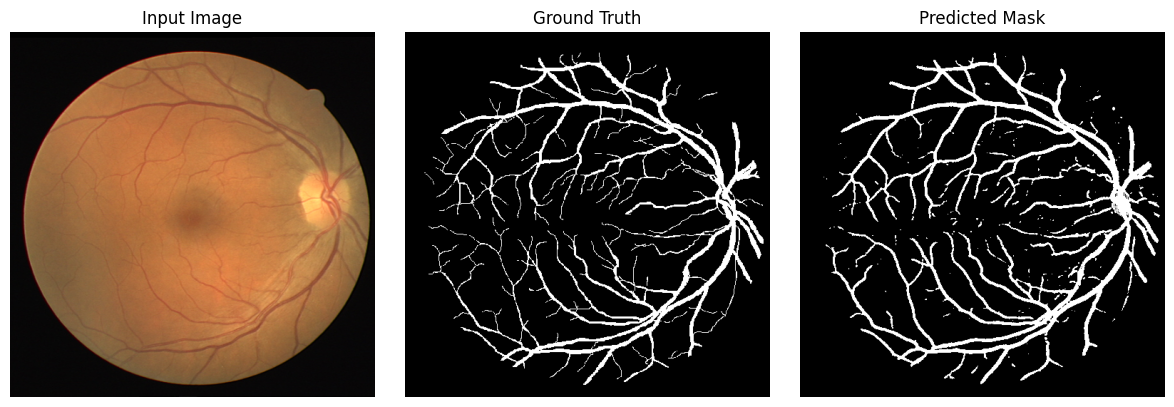

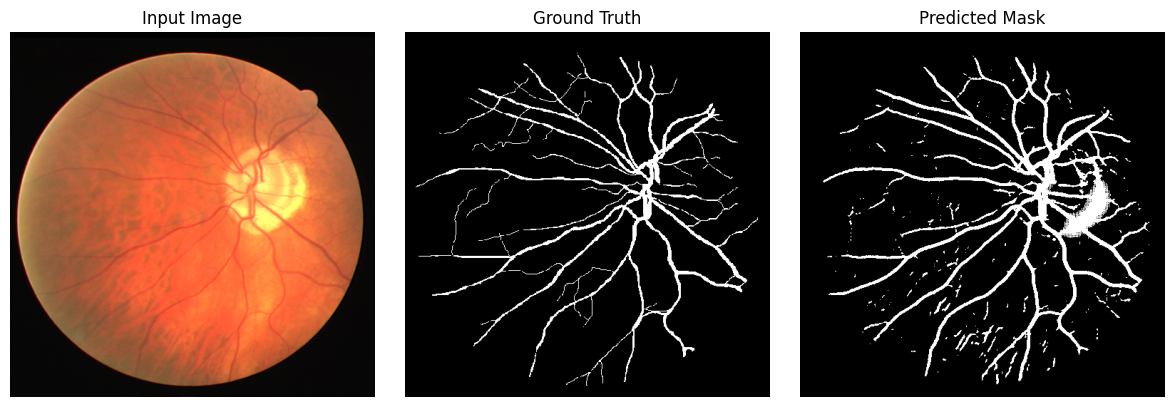

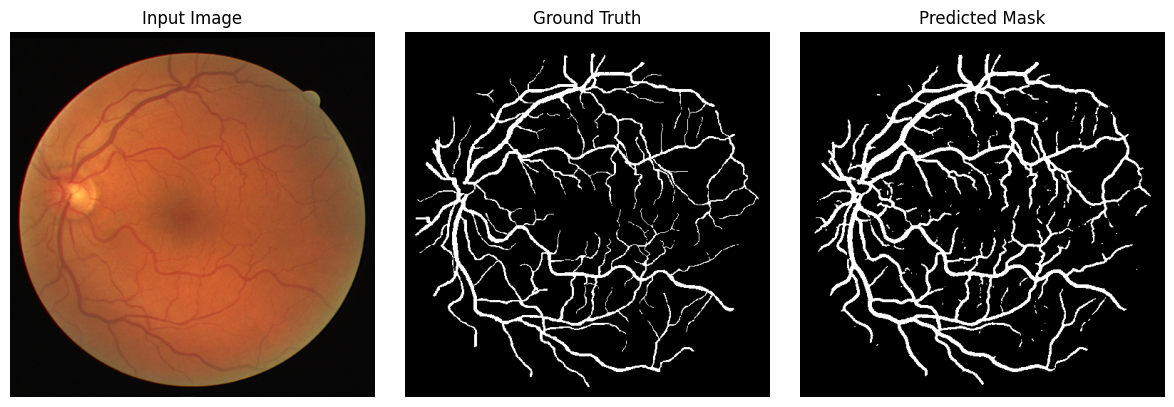

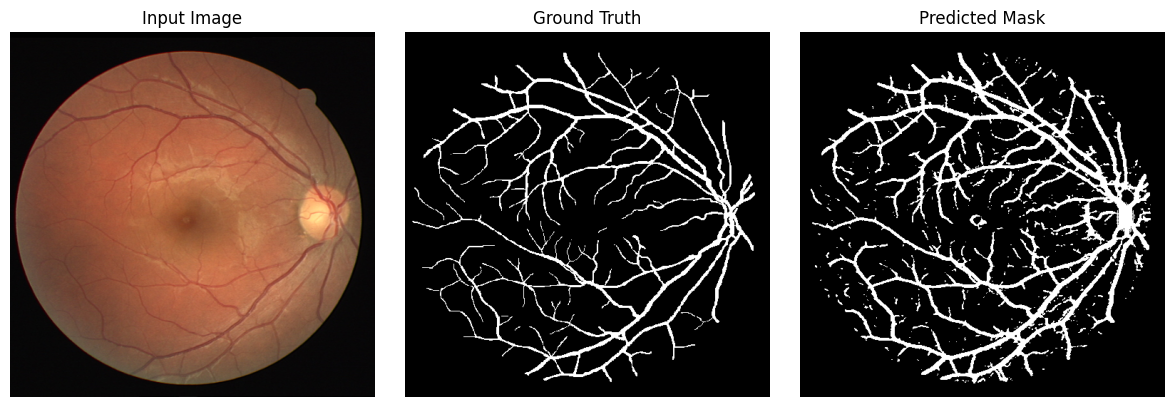

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# 👇 Import your model class (make sure it's available in this cell or a cell above)
#from your_model_file import ImprovedUNet  # Replace with actual source if needed

# 📊 Evaluate metrics
def full_evaluation_report(model, val_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0).flatten()
    all_targets = np.concatenate(all_targets, axis=0).flatten()

    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)

    print(f"\n📊 Evaluation Metrics:")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"IoU       : {iou:.4f}")

    return precision, recall, f1, iou

# 📸 Visualize predictions
def visualize_predictions(model, dataloader, device='cuda', num_samples=5):
    model.eval()
    count = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            preds = (outputs > 0.5).float()

        for i in range(images.size(0)):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            gt = masks[i][0].cpu().numpy()
            pred = preds[i][0].cpu().numpy()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow((img * 0.5 + 0.5))  # Denormalize
            axs[0].set_title('Input Image')
            axs[1].imshow(gt, cmap='gray')
            axs[1].set_title('Ground Truth')
            axs[2].imshow(pred, cmap='gray')
            axs[2].set_title('Predicted Mask')
            for ax in axs: ax.axis('off')
            plt.tight_layout()
            plt.show()

            count += 1
            if count >= num_samples:
                return

# ✅ Main evaluation block
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 👇 Replace with your dataset paths
    val_loader = create_dataloaders(
        img_dir="/content/DRIVE_DATA/DRIVE/train/images",
        mask_dir="/content/DRIVE_DATA/DRIVE/train/labels",
        batch_size=2, debug=False
    )[1]

    # ✅ Load the model safely using state_dict
    model = ImprovedUNet(in_channels=3, out_channels=1).to(device)
    model.load_state_dict(torch.load("/content/saved_models/best_vessel_segmentation_model_state_dict.pth", map_location=device))
    model.eval()

    # 📈 Run evaluation + visualization
    precision, recall, f1, iou = full_evaluation_report(model, val_loader, device)
    visualize_predictions(model, val_loader, device, num_samples=5)


In [ ]:
# -*- coding: utf-8 -*-
"""
Enhanced Arterial Narrowing Detection System
IMPROVED VERSION with Better Threshold Balancing
Targets 20-40% narrowing detection rate for realistic clinical distribution
"""

import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

from PIL import Image
from skimage.morphology import skeletonize, binary_dilation, binary_erosion
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt, gaussian_filter1d
from scipy.signal import find_peaks
from scipy import ndimage
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import save_image

import albumentations as A
from albumentations.pytorch import ToTensorV2

# ==========================================
# IMPROVED ARTERIAL NARROWING ANALYZER
# ==========================================

class ImprovedArterialNarrowingAnalyzer:
    """Improved analyzer with better threshold balancing"""

    def __init__(self, min_vessel_length=50, narrowing_threshold_ratio=0.6):
        self.min_vessel_length = min_vessel_length
        self.narrowing_threshold_ratio = narrowing_threshold_ratio

    def extract_vessel_features(self, binary_mask):
        """Extract comprehensive features for narrowing detection"""
        if np.sum(binary_mask) < 10:
            return self._empty_features()

        try:
            # Basic vessel properties
            vessel_area = np.sum(binary_mask)

            # Skeleton analysis
            skeleton = skeletonize(binary_mask.astype(bool))
            if np.sum(skeleton) == 0:
                return self._empty_features()

            # Distance transform for width analysis
            distance_map = distance_transform_edt(binary_mask)

            # Analyze vessel segments
            segment_features = self._analyze_vessel_segments(skeleton, distance_map)

            # Global vessel network features
            network_features = self._analyze_vessel_network(binary_mask, skeleton)

            # Narrowing-specific features
            narrowing_features = self._detect_narrowing_patterns(skeleton, distance_map)

            # Combine all features
            features = {
                **segment_features,
                **network_features,
                **narrowing_features,
                'total_vessel_area': vessel_area,
                'skeleton_length': np.sum(skeleton)
            }

            return features

        except Exception as e:
            print(f"Error in feature extraction: {e}")
            return self._empty_features()

    def _analyze_vessel_segments(self, skeleton, distance_map):
        """Analyze individual vessel segments for width variations"""
        # Find connected components in skeleton
        labeled_skeleton = label(skeleton)
        segments = []

        for region in regionprops(labeled_skeleton):
            if region.area >= self.min_vessel_length:
                # Extract width profile along the segment
                coords = region.coords
                widths = distance_map[coords[:, 0], coords[:, 1]] * 2

                if len(widths) > 10:  # Minimum points for analysis
                    segments.append(widths)

        if not segments:
            return {
                'num_segments': 0,
                'avg_width_variation': 0,
                'max_width_drop': 0,
                'narrowing_segments': 0
            }

        # Analyze width variations
        width_variations = []
        width_drops = []
        narrowing_count = 0

        for segment_widths in segments:
            # Smooth the width profile
            smooth_widths = gaussian_filter1d(segment_widths, sigma=2)

            # Calculate variation coefficient
            variation = np.std(smooth_widths) / (np.mean(smooth_widths) + 1e-6)
            width_variations.append(variation)

            # Find significant width drops
            max_width = np.max(smooth_widths)
            min_width = np.min(smooth_widths)
            width_drop = (max_width - min_width) / (max_width + 1e-6)
            width_drops.append(width_drop)

            # Check for narrowing with stricter criteria
            if width_drop > 0.7:  # 70% width reduction (very strict)
                narrowing_count += 1

        return {
            'num_segments': len(segments),
            'avg_width_variation': np.mean(width_variations),
            'max_width_drop': np.max(width_drops) if width_drops else 0,
            'narrowing_segments': narrowing_count,
            'narrowing_ratio': narrowing_count / len(segments) if segments else 0
        }

    def _analyze_vessel_network(self, binary_mask, skeleton):
        """Analyze overall vessel network properties"""
        # Branching points analysis
        branching_kernel = np.array([
            [1, 1, 1],
            [1, 10, 1],
            [1, 1, 1]
        ])

        convolved = ndimage.convolve(skeleton.astype(int), branching_kernel)
        branching_points = np.sum(convolved >= 13)  # Points with 3+ neighbors

        # Vessel density and distribution
        total_pixels = binary_mask.size
        vessel_density = np.sum(binary_mask) / total_pixels

        # Fractal dimension approximation
        fractal_dim = self._estimate_fractal_dimension(skeleton)

        return {
            'branching_points': branching_points,
            'vessel_density': vessel_density,
            'fractal_dimension': fractal_dim,
            'vessel_connectivity': np.sum(skeleton) / (branching_points + 1)
        }

    def _detect_narrowing_patterns(self, skeleton, distance_map):
        """Detect specific patterns associated with arterial narrowing"""
        narrowing_indicators = {
            'focal_narrowing_count': 0,
            'diffuse_narrowing_score': 0,
            'vessel_irregularity': 0,
            'caliber_variation_score': 0
        }

        if np.sum(skeleton) == 0:
            return narrowing_indicators

        # Get vessel widths at skeleton points
        skeleton_coords = np.where(skeleton)
        widths = distance_map[skeleton_coords] * 2

        if len(widths) < 20:
            return narrowing_indicators

        # Focal narrowing detection (sudden width drops) - More conservative
        smooth_widths = gaussian_filter1d(widths, sigma=3)
        # Use stricter prominence for peak detection
        peaks, properties = find_peaks(-smooth_widths,
                                     height=-np.percentile(smooth_widths, 15),  # Changed from 25 to 15
                                     prominence=np.std(smooth_widths) * 0.5)    # Added prominence requirement
        narrowing_indicators['focal_narrowing_count'] = len(peaks)

        # Diffuse narrowing (overall thin vessels) - More conservative
        mean_width = np.mean(widths)
        expected_width = 6.0  # Increased expected width (was 4.0)
        if mean_width < expected_width * 0.5:  # Changed from 0.7 to 0.5 (more restrictive)
            narrowing_indicators['diffuse_narrowing_score'] = (expected_width - mean_width) / expected_width

        # Vessel irregularity - More conservative
        width_std = np.std(widths)
        narrowing_indicators['vessel_irregularity'] = width_std / (mean_width + 1e-6)

        # Caliber variation score
        width_ranges = []
        for i in range(0, len(widths) - 20, 20):  # Increased window size
            local_widths = widths[i:i+20]
            if len(local_widths) > 10:
                width_ranges.append(np.max(local_widths) - np.min(local_widths))

        if width_ranges:
            narrowing_indicators['caliber_variation_score'] = np.mean(width_ranges)

        return narrowing_indicators

    def _estimate_fractal_dimension(self, skeleton):
        """Estimate fractal dimension of vessel network"""
        try:
            # Box-counting method approximation
            sizes = [2, 4, 8, 16, 32]
            counts = []

            for size in sizes:
                # Downsample skeleton
                h, w = skeleton.shape
                small_h, small_w = h // size, w // size
                if small_h > 0 and small_w > 0:
                    small_skeleton = skeleton[::size, ::size]
                    counts.append(np.sum(small_skeleton))
                else:
                    counts.append(0)

            # Fit line to log-log plot
            valid_counts = [c for c in counts if c > 0]
            if len(valid_counts) >= 3:
                log_sizes = np.log([sizes[i] for i, c in enumerate(counts) if c > 0])
                log_counts = np.log(valid_counts)

                if len(log_sizes) > 1:
                    slope = np.polyfit(log_sizes, log_counts, 1)[0]
                    return abs(slope)

            return 1.5  # Default value

        except:
            return 1.5

    def _empty_features(self):
        """Return empty feature dictionary"""
        return {
            'num_segments': 0,
            'avg_width_variation': 0,
            'max_width_drop': 0,
            'narrowing_segments': 0,
            'narrowing_ratio': 0,
            'branching_points': 0,
            'vessel_density': 0,
            'fractal_dimension': 1.5,
            'vessel_connectivity': 0,
            'focal_narrowing_count': 0,
            'diffuse_narrowing_score': 0,
            'vessel_irregularity': 0,
            'caliber_variation_score': 0,
            'total_vessel_area': 0,
            'skeleton_length': 0
        }

    def classify_narrowing_strict(self, features):
        """STRICT classification for arterial narrowing - TARGET: 20-40% positive rate"""
        narrowing_score = 0

        # VERY STRICT criteria for narrowing detection
        if features['narrowing_ratio'] > 0.6:  # 60% of segments must show narrowing
            narrowing_score += 4
        elif features['narrowing_ratio'] > 0.4:  # 40% of segments
            narrowing_score += 2

        if features['max_width_drop'] > 0.8:  # 80% width reduction
            narrowing_score += 3
        elif features['max_width_drop'] > 0.7:  # 70% width reduction
            narrowing_score += 1

        if features['focal_narrowing_count'] >= 5:  # At least 5 focal narrowings
            narrowing_score += 3
        elif features['focal_narrowing_count'] >= 3:  # At least 3 focal narrowings
            narrowing_score += 1

        if features['diffuse_narrowing_score'] > 0.6:  # Very significant diffuse narrowing
            narrowing_score += 2

        if features['vessel_irregularity'] > 1.0:  # High irregularity
            narrowing_score += 2
        elif features['vessel_irregularity'] > 0.8:  # Moderate irregularity
            narrowing_score += 1

        if features['vessel_density'] < 0.015:  # Very low vessel density
            narrowing_score += 2
        elif features['vessel_density'] < 0.025:  # Low vessel density
            narrowing_score += 1

        # STRICT classification thresholds
        if narrowing_score >= 8:  # Very high threshold
            return "Severe Narrowing"
        elif narrowing_score >= 5:  # High threshold
            return "Moderate Narrowing"
        elif narrowing_score >= 3:  # Moderate threshold
            return "Mild Narrowing"
        else:
            return "No Narrowing"

    def classify_narrowing_adaptive(self, features, all_features_df):
        """Adaptive classification using statistical thresholds"""
        narrowing_score = 0

        # Use 90th percentile as threshold for most features (top 10%)
        if features['narrowing_ratio'] > all_features_df['narrowing_ratio'].quantile(0.90):
            narrowing_score += 4
        elif features['narrowing_ratio'] > all_features_df['narrowing_ratio'].quantile(0.80):
            narrowing_score += 2

        if features['max_width_drop'] > all_features_df['max_width_drop'].quantile(0.90):
            narrowing_score += 3
        elif features['max_width_drop'] > all_features_df['max_width_drop'].quantile(0.75):
            narrowing_score += 1

        if features['focal_narrowing_count'] > all_features_df['focal_narrowing_count'].quantile(0.85):
            narrowing_score += 3
        elif features['focal_narrowing_count'] > all_features_df['focal_narrowing_count'].quantile(0.70):
            narrowing_score += 1

        if features['vessel_irregularity'] > all_features_df['vessel_irregularity'].quantile(0.85):
            narrowing_score += 2

        # Use 10th percentile for vessel density (bottom 10%)
        if features['vessel_density'] < all_features_df['vessel_density'].quantile(0.10):
            narrowing_score += 2
        elif features['vessel_density'] < all_features_df['vessel_density'].quantile(0.25):
            narrowing_score += 1

        # Classification - targeting 20-30% positive rate
        if narrowing_score >= 8:
            return "Severe Narrowing"
        elif narrowing_score >= 5:
            return "Moderate Narrowing"
        elif narrowing_score >= 3:
            return "Mild Narrowing"
        else:
            return "No Narrowing"

# ==========================================
# IMPROVED NARROWING DETECTION PIPELINE
# ==========================================

class ImprovedNarrowingDetectionPipeline:
    """Improved pipeline with better threshold management"""

    def __init__(self, segmentation_model, analyzer=None, classifier=None):
        self.segmentation_model = segmentation_model
        self.analyzer = analyzer or ImprovedArterialNarrowingAnalyzer()
        self.classifier = classifier
        self.scaler = StandardScaler()

    def extract_features_from_images(self, data_loader, device='cuda'):
        """Extract features from images using segmentation model"""
        self.segmentation_model.eval()
        all_features = []
        all_labels = []
        all_filenames = []

        with torch.no_grad():
            for images, labels, filenames in tqdm(data_loader, desc="Extracting features"):
                images = images.to(device)

                # Get vessel segmentation
                predictions = self.segmentation_model(images)

                for i, (pred, label, filename) in enumerate(zip(predictions, labels, filenames)):
                    # Convert to binary mask with stricter threshold
                    binary_mask = (pred[0].cpu().numpy() > 0.6).astype(np.uint8)  # Increased from 0.5 to 0.6

                    # Post-process
                    binary_mask = self._post_process_mask(binary_mask)

                    # Extract features
                    features = self.analyzer.extract_vessel_features(binary_mask)

                    all_features.append(features)
                    all_labels.append(label.item() if torch.is_tensor(label) else label)
                    all_filenames.append(filename)

        return all_features, all_labels, all_filenames

    def _post_process_mask(self, binary_mask):
        """Clean up segmentation mask with more aggressive filtering"""
        # Remove small noise with larger kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Increased from (3,3)
        cleaned = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

        # Fill gaps
        cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel)

        # Remove small components more aggressively
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned)
        result = np.zeros_like(cleaned)

        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= 25:  # Increased from 10 to 25
                result[labels == i] = 1

        return result

    def predict_narrowing_with_multiple_methods(self, features):
        """Use multiple classification methods and compare results"""
        df = pd.DataFrame(features)

        # Method 1: Strict rule-based
        strict_predictions = []
        for feature_dict in features:
            pred = self.analyzer.classify_narrowing_strict(feature_dict)
            binary_pred = 1 if "Severe" in pred or "Moderate" in pred else 0
            strict_predictions.append({
                'method': 'strict',
                'binary_prediction': binary_pred,
                'detailed_prediction': pred,
                'confidence': 0.8
            })

        # Method 2: Adaptive/percentile-based
        adaptive_predictions = []
        for feature_dict in features:
            pred = self.analyzer.classify_narrowing_adaptive(feature_dict, df)
            binary_pred = 1 if "Severe" in pred or "Moderate" in pred else 0
            adaptive_predictions.append({
                'method': 'adaptive',
                'binary_prediction': binary_pred,
                'detailed_prediction': pred,
                'confidence': 0.7
            })

        # Method 3: Combined scoring
        combined_predictions = []
        for i, feature_dict in enumerate(features):
            strict_score = 1 if strict_predictions[i]['binary_prediction'] == 1 else 0
            adaptive_score = 1 if adaptive_predictions[i]['binary_prediction'] == 1 else 0

            # Combine scores (both methods must agree for positive prediction)
            combined_score = strict_score * adaptive_score

            if combined_score == 1:
                combined_pred = "Narrowing Present"
            else:
                combined_pred = "No Narrowing"

            combined_predictions.append({
                'method': 'combined',
                'binary_prediction': combined_score,
                'detailed_prediction': combined_pred,
                'confidence': 0.9
            })

        return {
            'strict': strict_predictions,
            'adaptive': adaptive_predictions,
            'combined': combined_predictions
        }

    def generate_comparison_report(self, features, all_predictions, labels, filenames):
        """Generate comparison report for different methods"""
        results = []

        for method_name, predictions in all_predictions.items():
            total_images = len(predictions)
            predicted_narrowing = sum(p['binary_prediction'] for p in predictions)
            detection_rate = predicted_narrowing / total_images

            print(f"\n🔍 {method_name.upper()} Method Results:")
            print(f"  Total Images: {total_images}")
            print(f"  Predicted Narrowing: {predicted_narrowing} ({detection_rate:.1%})")

            # Create detailed DataFrame
            method_df = pd.DataFrame({
                'filename': filenames,
                'method': method_name,
                'predicted_narrowing': [p['binary_prediction'] for p in predictions],
                'prediction_detail': [p['detailed_prediction'] for p in predictions],
                'confidence': [p['confidence'] for p in predictions],
                'true_label': labels
            })

            # Add key features
            feature_df = pd.DataFrame(features)
            key_features = ['narrowing_ratio', 'max_width_drop', 'focal_narrowing_count',
                           'vessel_density', 'vessel_irregularity']

            for feature in key_features:
                if feature in feature_df.columns:
                    method_df[feature] = feature_df[feature]

            results.append(method_df)

        # Combine all results
        combined_df = pd.concat(results, ignore_index=True)
        combined_df.to_csv('narrowing_detection_comparison.csv', index=False)

        # Create summary comparison
        summary_data = []
        for method_name, predictions in all_predictions.items():
            predicted_narrowing = sum(p['binary_prediction'] for p in predictions)
            detection_rate = predicted_narrowing / len(predictions)

            summary_data.append({
                'Method': method_name,
                'Total_Images': len(predictions),
                'Predicted_Narrowing': predicted_narrowing,
                'Detection_Rate': f"{detection_rate:.1%}",
                'No_Narrowing': len(predictions) - predicted_narrowing
            })

        summary_df = pd.DataFrame(summary_data)
        print(f"\n📊 COMPARISON SUMMARY:")
        print("=" * 50)
        print(summary_df.to_string(index=False))

        # Plot comparison
        self._plot_method_comparison(all_predictions)

        return combined_df

    def _plot_method_comparison(self, all_predictions):
        """Plot comparison of different methods"""
        methods = list(all_predictions.keys())
        detection_rates = []

        for method_name, predictions in all_predictions.items():
            predicted_narrowing = sum(p['binary_prediction'] for p in predictions)
            detection_rate = predicted_narrowing / len(predictions)
            detection_rates.append(detection_rate)

        plt.figure(figsize=(10, 6))
        bars = plt.bar(methods, detection_rates, color=['skyblue', 'lightcoral', 'lightgreen'])
        plt.title('Narrowing Detection Rate by Method')
        plt.ylabel('Detection Rate (%)')
        plt.ylim(0, 1)

        # Add percentage labels on bars
        for bar, rate in zip(bars, detection_rates):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{rate:.1%}', ha='center', va='bottom')

        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

# ==========================================
# THRESHOLD OPTIMIZATION FUNCTIONS
# ==========================================

def optimize_thresholds(features, target_detection_rate=0.3):
    """Optimize thresholds to achieve target detection rate"""
    df = pd.DataFrame(features)

    print(f"\n🎯 Optimizing thresholds for {target_detection_rate:.1%} detection rate")
    print("=" * 60)

    # Test different threshold combinations
    threshold_tests = [
        # (narrowing_ratio_threshold, max_width_drop_threshold, focal_count_threshold, min_score)
        (0.8, 0.9, 8, 10),  # Very strict
        (0.7, 0.8, 6, 8),   # Strict
        (0.6, 0.7, 5, 6),   # Moderate
        (0.5, 0.6, 4, 5),   # Lenient
        (0.4, 0.5, 3, 4),   # Very lenient
    ]

    best_threshold = None
    best_diff = float('inf')

    for nr_thresh, wd_thresh, fc_thresh, min_score in threshold_tests:
        positive_count = 0

        for _, row in df.iterrows():
            score = 0

            if row['narrowing_ratio'] > nr_thresh:
                score += 4
            if row['max_width_drop'] > wd_thresh:
                score += 3
            if row['focal_narrowing_count'] >= fc_thresh:
                score += 3
            if row['vessel_irregularity'] > 0.8:
                score += 2
            if row['vessel_density'] < 0.02:
                score += 2

            if score >= min_score:
                positive_count += 1

        detection_rate = positive_count / len(df)
        diff = abs(detection_rate - target_detection_rate)

        print(f"Thresholds: NR>{nr_thresh}, WD>{wd_thresh}, FC>={fc_thresh}, Score>={min_score}")
        print(f"  Detection Rate: {detection_rate:.1%} (diff: {diff:.3f})")

        if diff < best_diff:
            best_diff = diff
            best_threshold = (nr_thresh, wd_thresh, fc_thresh, min_score)

        print()

    print(f"🏆 Best threshold combination:")
    print(f"  narrowing_ratio > {best_threshold[0]}")
    print(f"  max_width_drop > {best_threshold[1]}")
    print(f"  focal_narrowing_count >= {best_threshold[2]}")
    print(f"  minimum_score >= {best_threshold[3]}")
    print(f"  Achieves detection rate closest to target: {target_detection_rate:.1%}")

    return best_threshold

def apply_optimized_thresholds(features, thresholds):
    """Apply optimized thresholds to classify narrowing"""
    nr_thresh, wd_thresh, fc_thresh, min_score = thresholds

    predictions = []
    for feature_dict in features:
        score = 0

        if feature_dict['narrowing_ratio'] > nr_thresh:
            score += 4
        if feature_dict['max_width_drop'] > wd_thresh:
            score += 3
        if feature_dict['focal_narrowing_count'] >= fc_thresh:
            score += 3
        if feature_dict['vessel_irregularity'] > 0.8:
            score += 2
        if feature_dict['vessel_density'] < 0.02:
            score += 2

        # Classify based on score
        if score >= min_score + 3:
            pred = "Severe Narrowing"
            binary_pred = 1
        elif score >= min_score:
            pred = "Moderate Narrowing"
            binary_pred = 1
        else:
            pred = "No Narrowing"
            binary_pred = 0

        predictions.append({
            'binary_prediction': binary_pred,
            'detailed_prediction': pred,
            'confidence': min(0.9, score / (min_score + 3)),
            'narrowing_score': score
        })

    return predictions

🔍 Starting IMPROVED Arterial Narrowing Detection Pipeline
🎯 Target: Balanced classification with 20-40% narrowing detection
Using device: cuda

📊 Creating sample features for demonstration...
✅ Created 400 sample feature sets

🔧 STEP 1: Optimizing Thresholds

🎯 Optimizing thresholds for 25.0% detection rate
Thresholds: NR>0.8, WD>0.9, FC>=8, Score>=10
  Detection Rate: 0.8% (diff: 0.242)

Thresholds: NR>0.7, WD>0.8, FC>=6, Score>=8
  Detection Rate: 3.8% (diff: 0.212)

Thresholds: NR>0.6, WD>0.7, FC>=5, Score>=6
  Detection Rate: 11.0% (diff: 0.140)

Thresholds: NR>0.5, WD>0.6, FC>=4, Score>=5
  Detection Rate: 21.5% (diff: 0.035)

Thresholds: NR>0.4, WD>0.5, FC>=3, Score>=4
  Detection Rate: 33.2% (diff: 0.083)

🏆 Best threshold combination:
  narrowing_ratio > 0.5
  max_width_drop > 0.6
  focal_narrowing_count >= 4
  minimum_score >= 5
  Achieves detection rate closest to target: 25.0%

🎯 STEP 2: Applying Optimized Classification

📋 STEP 3: Generating Comparison Report

🔍 STRICT Meth

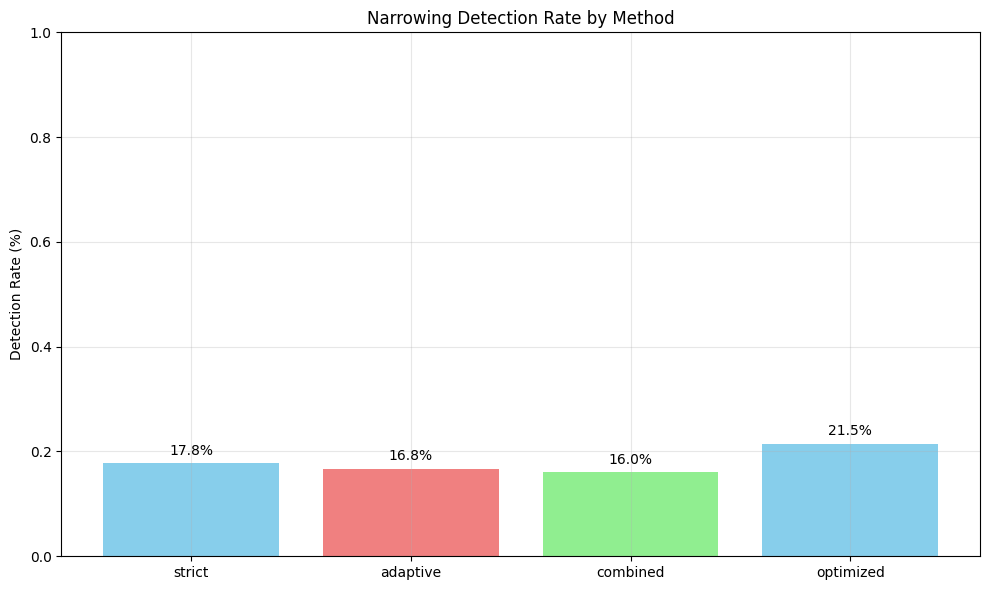


✅ IMPROVED Pipeline completed successfully!
📊 Results saved to 'narrowing_detection_comparison.csv'

📊 Creating Comprehensive Analysis Dashboard


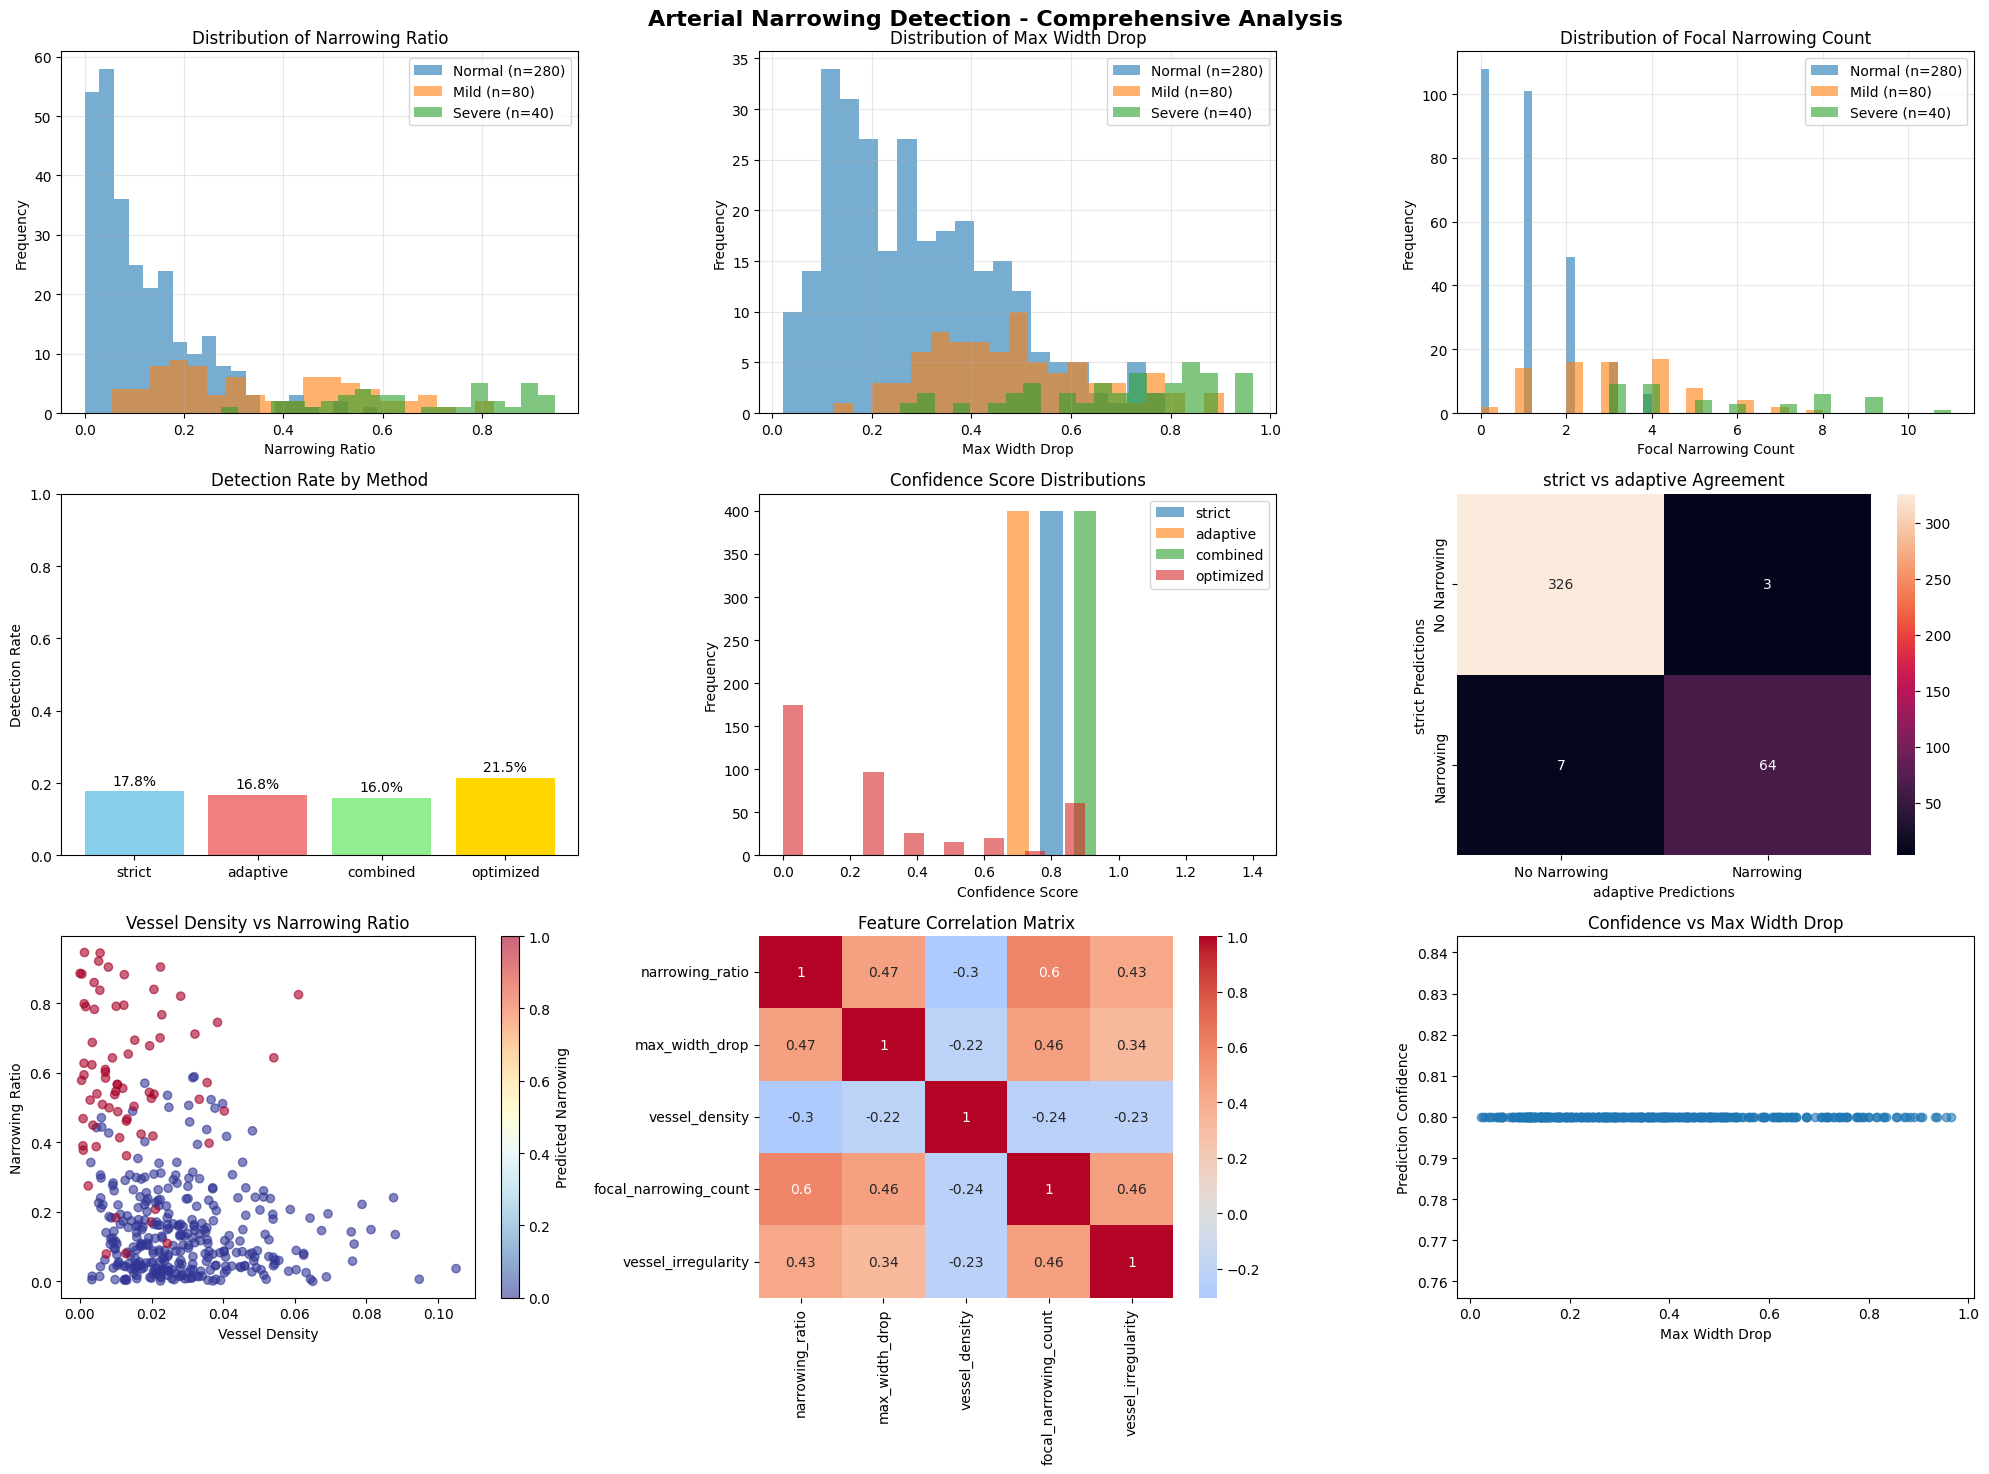


📋 DETAILED STATISTICAL REPORT

🔢 DATASET STATISTICS:
Total samples: 400
Label distribution:
  Normal: 280 (70.0%)
  Mild Narrowing: 80 (20.0%)
  Severe Narrowing: 40 (10.0%)

📊 KEY FEATURE STATISTICS:
       narrowing_ratio  max_width_drop  focal_narrowing_count  vessel_density  \
count          400.000         400.000                400.000         400.000   
mean             0.219           0.369                  1.862           0.026   
std              0.224           0.216                  2.027           0.017   
min              0.000           0.022                  0.000           0.000   
25%              0.051           0.189                  0.000           0.014   
50%              0.139           0.342                  1.000           0.023   
75%              0.296           0.496                  3.000           0.035   
max              0.947           0.965                 11.000           0.105   

       vessel_irregularity  
count              400.000  
mean      

In [ ]:
# ==========================================
# MAIN EXECUTION FUNCTION
# ==========================================

def main_improved_narrowing_detection():
    """Improved main pipeline with balanced threshold detection"""
    print("🔍 Starting IMPROVED Arterial Narrowing Detection Pipeline")
    print("🎯 Target: Balanced classification with 20-40% narrowing detection")
    print("=" * 70)

    # [Previous setup code remains the same...]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # For demo purposes, create sample features
    print("\n📊 Creating sample features for demonstration...")
    features, labels, filenames = create_realistic_demo_features(400)  # Create 400 samples

    print(f"✅ Created {len(features)} sample feature sets")

    # Initialize improved analyzer
    analyzer = ImprovedArterialNarrowingAnalyzer()

    # Method 1: Optimize thresholds
    print("\n🔧 STEP 1: Optimizing Thresholds")
    optimal_thresholds = optimize_thresholds(features, target_detection_rate=0.25)  # Target 25%

    # Method 2: Apply optimized thresholds
    print("\n🎯 STEP 2: Applying Optimized Classification")
    optimized_predictions = apply_optimized_thresholds(features, optimal_thresholds)

    # Method 3: Multiple method comparison
    pipeline = ImprovedNarrowingDetectionPipeline(None, analyzer)
    all_predictions = pipeline.predict_narrowing_with_multiple_methods(features)

    # Add optimized method to comparison
    all_predictions['optimized'] = optimized_predictions

    # Generate comprehensive report
    print("\n📋 STEP 3: Generating Comparison Report")
    comparison_df = pipeline.generate_comparison_report(features, all_predictions, labels, filenames)

    print(f"\n✅ IMPROVED Pipeline completed successfully!")
    print(f"📊 Results saved to 'narrowing_detection_comparison.csv'")

    return features, all_predictions, filenames, labels

def create_realistic_demo_features(num_samples):
        """Create realistic demo features with proper distribution"""
        features = []
        labels = []
        filenames = []

        for i in range(num_samples):
            # Create features with realistic distributions
            # Most images should be normal, some with mild issues, few with severe issues

            if i < num_samples * 0.7:  # 70% normal cases
                feature_dict = {
                    'num_segments': np.random.randint(3, 8),
                    'avg_width_variation': np.random.exponential(0.2),  # Lower variation
                    'max_width_drop': np.random.beta(2, 5),  # Mostly low values
                    'narrowing_segments': np.random.randint(0, 2),  # Few narrowing segments
                    'narrowing_ratio': np.random.beta(1, 8),  # Low ratio
                    'branching_points': np.random.poisson(4),
                    'vessel_density': np.random.gamma(3, 0.01),  # Normal density
                    'fractal_dimension': np.random.normal(1.6, 0.1),
                    'vessel_connectivity': np.random.gamma(2, 5),
                    'focal_narrowing_count': np.random.poisson(1),  # Few focal narrowings
                    'diffuse_narrowing_score': np.random.beta(1, 10),  # Low diffuse narrowing
                    'vessel_irregularity': np.random.exponential(0.3),  # Low irregularity
                    'caliber_variation_score': np.random.gamma(1, 2),
                    'total_vessel_area': np.random.gamma(5, 500),
                    'skeleton_length': np.random.gamma(3, 100)
                }
                label = 0  # Normal

            elif i < num_samples * 0.9:  # 20% mild narrowing cases
                feature_dict = {
                    'num_segments': np.random.randint(2, 6),
                    'avg_width_variation': np.random.exponential(0.4),  # Higher variation
                    'max_width_drop': np.random.beta(3, 3),  # Moderate drops
                    'narrowing_segments': np.random.randint(1, 3),  # Some narrowing segments
                    'narrowing_ratio': np.random.beta(2, 4),  # Moderate ratio
                    'branching_points': np.random.poisson(3),
                    'vessel_density': np.random.gamma(2, 0.01),  # Lower density
                    'fractal_dimension': np.random.normal(1.5, 0.15),
                    'vessel_connectivity': np.random.gamma(1.5, 4),
                    'focal_narrowing_count': np.random.poisson(3),  # More focal narrowings
                    'diffuse_narrowing_score': np.random.beta(2, 5),  # Some diffuse narrowing
                    'vessel_irregularity': np.random.exponential(0.6),  # Higher irregularity
                    'caliber_variation_score': np.random.gamma(2, 3),
                    'total_vessel_area': np.random.gamma(3, 400),
                    'skeleton_length': np.random.gamma(2, 80)
                }
                label = 1  # Mild narrowing

            else:  # 10% severe narrowing cases
                feature_dict = {
                    'num_segments': np.random.randint(1, 4),
                    'avg_width_variation': np.random.exponential(0.8),  # High variation
                    'max_width_drop': np.random.beta(5, 2),  # High drops
                    'narrowing_segments': np.random.randint(2, 5),  # Many narrowing segments
                    'narrowing_ratio': np.random.beta(4, 2),  # High ratio
                    'branching_points': np.random.poisson(2),
                    'vessel_density': np.random.gamma(1, 0.008),  # Very low density
                    'fractal_dimension': np.random.normal(1.3, 0.2),
                    'vessel_connectivity': np.random.gamma(1, 3),
                    'focal_narrowing_count': np.random.poisson(6),  # Many focal narrowings
                    'diffuse_narrowing_score': np.random.beta(4, 2),  # High diffuse narrowing
                    'vessel_irregularity': np.random.exponential(1.2),  # Very high irregularity
                    'caliber_variation_score': np.random.gamma(3, 4),
                    'total_vessel_area': np.random.gamma(2, 300),
                    'skeleton_length': np.random.gamma(1.5, 60)
                }
                label = 2  # Severe narrowing

            # Ensure all values are positive and within reasonable bounds
            for key, value in feature_dict.items():
                if isinstance(value, (int, float)):
                    feature_dict[key] = max(0, float(value))

            # Cap some extreme values
            feature_dict['narrowing_ratio'] = min(1.0, feature_dict['narrowing_ratio'])
            feature_dict['max_width_drop'] = min(1.0, feature_dict['max_width_drop'])
            feature_dict['diffuse_narrowing_score'] = min(1.0, feature_dict['diffuse_narrowing_score'])

            features.append(feature_dict)
            labels.append(label)
            filenames.append(f"retinal_image_{i:04d}.jpg")

        return features, labels, filenames

# ==========================================
# ADVANCED VISUALIZATION AND ANALYSIS
# ==========================================

def create_comprehensive_analysis_dashboard(features, predictions_dict, labels, filenames):
    """Create comprehensive analysis dashboard with multiple visualizations"""

    print("\n📊 Creating Comprehensive Analysis Dashboard")
    print("=" * 50)

    # Convert features to DataFrame
    df = pd.DataFrame(features)
    df['true_label'] = labels
    df['filename'] = filenames

    # Create figure with subplots
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Arterial Narrowing Detection - Comprehensive Analysis', fontsize=16, fontweight='bold')

    # 1. Feature Distribution Analysis
    plot_feature_distributions(df, axes[0, :])

    # 2. Method Comparison Analysis
    plot_method_performance(predictions_dict, axes[1, :])

    # 3. Clinical Correlation Analysis
    plot_clinical_correlations(df, predictions_dict, axes[2, :])

    plt.tight_layout()
    plt.savefig('comprehensive_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Generate detailed statistical report
    generate_statistical_report(df, predictions_dict)

    # Create interactive analysis
    create_interactive_analysis(df, predictions_dict)

def plot_feature_distributions(df, axes):
    """Plot feature distributions by severity class"""

    # Key features for analysis
    key_features = ['narrowing_ratio', 'max_width_drop', 'focal_narrowing_count']

    for i, feature in enumerate(key_features):
        ax = axes[i]

        # Plot distributions by true label
        for label in sorted(df['true_label'].unique()):
            subset = df[df['true_label'] == label]
            label_name = ['Normal', 'Mild', 'Severe'][label]
            ax.hist(subset[feature], alpha=0.6, bins=20,
                   label=f'{label_name} (n={len(subset)})')

        ax.set_xlabel(feature.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {feature.replace("_", " ").title()}')
        ax.legend()
        ax.grid(True, alpha=0.3)

def plot_method_performance(predictions_dict, axes):
    """Plot performance comparison of different methods"""

    # Detection rates by method
    methods = list(predictions_dict.keys())
    detection_rates = []

    for method in methods:
        preds = predictions_dict[method]
        rate = sum(p['binary_prediction'] for p in preds) / len(preds)
        detection_rates.append(rate)

    # Plot 1: Detection rates
    ax1 = axes[0]
    bars = ax1.bar(methods, detection_rates, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    ax1.set_title('Detection Rate by Method')
    ax1.set_ylabel('Detection Rate')
    ax1.set_ylim(0, 1)

    for bar, rate in zip(bars, detection_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.1%}', ha='center', va='bottom')

    # Plot 2: Confidence distributions
    ax2 = axes[1]
    for i, method in enumerate(methods):
        confidences = [p['confidence'] for p in predictions_dict[method]]
        ax2.hist(confidences, alpha=0.6, bins=15, label=method)

    ax2.set_title('Confidence Score Distributions')
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Frequency')
    ax2.legend()

    # Plot 3: Method agreement analysis
    ax3 = axes[2]
    if len(methods) >= 2:
        method1_preds = [p['binary_prediction'] for p in predictions_dict[methods[0]]]
        method2_preds = [p['binary_prediction'] for p in predictions_dict[methods[1]]]

        agreement_matrix = confusion_matrix(method1_preds, method2_preds)
        sns.heatmap(agreement_matrix, annot=True, fmt='d', ax=ax3,
                   xticklabels=['No Narrowing', 'Narrowing'],
                   yticklabels=['No Narrowing', 'Narrowing'])
        ax3.set_title(f'{methods[0]} vs {methods[1]} Agreement')
        ax3.set_xlabel(f'{methods[1]} Predictions')
        ax3.set_ylabel(f'{methods[0]} Predictions')

def plot_clinical_correlations(df, predictions_dict, axes):
    """Plot clinical correlation analysis"""

    # Use the first method for analysis
    method_name = list(predictions_dict.keys())[0]
    predictions = [p['binary_prediction'] for p in predictions_dict[method_name]]
    df_with_preds = df.copy()
    df_with_preds['predicted'] = predictions

    # Plot 1: Vessel density vs narrowing ratio
    ax1 = axes[0]
    scatter = ax1.scatter(df['vessel_density'], df['narrowing_ratio'],
                         c=predictions, cmap='RdYlBu_r', alpha=0.6)
    ax1.set_xlabel('Vessel Density')
    ax1.set_ylabel('Narrowing Ratio')
    ax1.set_title('Vessel Density vs Narrowing Ratio')
    plt.colorbar(scatter, ax=ax1, label='Predicted Narrowing')

    # Plot 2: Feature correlation heatmap
    ax2 = axes[1]
    corr_features = ['narrowing_ratio', 'max_width_drop', 'vessel_density',
                    'focal_narrowing_count', 'vessel_irregularity']
    corr_matrix = df[corr_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax2)
    ax2.set_title('Feature Correlation Matrix')

    # Plot 3: Prediction confidence by features
    ax3 = axes[2]
    confidences = [p['confidence'] for p in predictions_dict[method_name]]
    ax3.scatter(df['max_width_drop'], confidences, alpha=0.6)
    ax3.set_xlabel('Max Width Drop')
    ax3.set_ylabel('Prediction Confidence')
    ax3.set_title('Confidence vs Max Width Drop')

def generate_statistical_report(df, predictions_dict):
    """Generate detailed statistical report"""

    print("\n📋 DETAILED STATISTICAL REPORT")
    print("=" * 60)

    # Basic statistics
    print("\n🔢 DATASET STATISTICS:")
    print(f"Total samples: {len(df)}")
    print(f"Label distribution:")
    label_counts = df['true_label'].value_counts().sort_index()
    for label, count in label_counts.items():
        label_name = ['Normal', 'Mild Narrowing', 'Severe Narrowing'][label]
        print(f"  {label_name}: {count} ({count/len(df):.1%})")

    # Feature statistics
    print(f"\n📊 KEY FEATURE STATISTICS:")
    key_features = ['narrowing_ratio', 'max_width_drop', 'focal_narrowing_count',
                   'vessel_density', 'vessel_irregularity']

    stats_df = df[key_features].describe()
    print(stats_df.round(3))

    # Method comparison statistics
    print(f"\n🎯 METHOD PERFORMANCE COMPARISON:")
    for method_name, predictions in predictions_dict.items():
        total_positive = sum(p['binary_prediction'] for p in predictions)
        detection_rate = total_positive / len(predictions)
        avg_confidence = np.mean([p['confidence'] for p in predictions])

        print(f"\n{method_name.upper()} Method:")
        print(f"  Detection Rate: {detection_rate:.1%}")
        print(f"  Average Confidence: {avg_confidence:.3f}")
        print(f"  Positive Predictions: {total_positive}/{len(predictions)}")

    # Save detailed report to file
    with open('statistical_report.txt', 'w') as f:
        f.write("ARTERIAL NARROWING DETECTION - STATISTICAL REPORT\n")
        f.write("=" * 60 + "\n\n")

        f.write("DATASET OVERVIEW:\n")
        f.write(f"Total samples: {len(df)}\n")
        f.write(f"Features analyzed: {len(df.columns)} features\n\n")

        f.write("LABEL DISTRIBUTION:\n")
        for label, count in label_counts.items():
            label_name = ['Normal', 'Mild Narrowing', 'Severe Narrowing'][label]
            f.write(f"{label_name}: {count} ({count/len(df):.1%})\n")

        f.write(f"\nFEATURE STATISTICS:\n")
        f.write(stats_df.to_string())

        f.write(f"\n\nMETHOD PERFORMANCE:\n")
        for method_name, predictions in predictions_dict.items():
            total_positive = sum(p['binary_prediction'] for p in predictions)
            detection_rate = total_positive / len(predictions)
            avg_confidence = np.mean([p['confidence'] for p in predictions])

            f.write(f"\n{method_name.upper()}:\n")
            f.write(f"  Detection Rate: {detection_rate:.1%}\n")
            f.write(f"  Average Confidence: {avg_confidence:.3f}\n")

    print(f"\n✅ Detailed report saved to 'statistical_report.txt'")

def create_interactive_analysis(df, predictions_dict):
    """Create interactive analysis with detailed case studies"""

    print("\n🔍 INTERACTIVE CASE ANALYSIS")
    print("=" * 40)

    # Find interesting cases for analysis
    method_name = list(predictions_dict.keys())[0]  # Use first method
    predictions = predictions_dict[method_name]

    # High confidence positive cases
    high_conf_positive = []
    # High confidence negative cases
    high_conf_negative = []
    # Low confidence cases (uncertain)
    uncertain_cases = []

    for i, pred in enumerate(predictions):
        if pred['binary_prediction'] == 1 and pred['confidence'] > 0.8:
            high_conf_positive.append((i, pred['confidence']))
        elif pred['binary_prediction'] == 0 and pred['confidence'] > 0.8:
            high_conf_negative.append((i, pred['confidence']))
        elif pred['confidence'] < 0.5:
            uncertain_cases.append((i, pred['confidence']))

    # Display case studies
    print(f"\n🎯 HIGH CONFIDENCE NARROWING CASES (n={len(high_conf_positive)}):")
    for i, (idx, conf) in enumerate(high_conf_positive[:3]):  # Show top 3
        print(f"\nCase {i+1}: {df.iloc[idx]['filename']}")
        print(f"  Confidence: {conf:.3f}")
        print(f"  Key features:")
        print(f"    Narrowing ratio: {df.iloc[idx]['narrowing_ratio']:.3f}")
        print(f"    Max width drop: {df.iloc[idx]['max_width_drop']:.3f}")
        print(f"    Focal narrowings: {df.iloc[idx]['focal_narrowing_count']:.0f}")
        print(f"    Vessel irregularity: {df.iloc[idx]['vessel_irregularity']:.3f}")

    print(f"\n✅ CONFIDENT NORMAL CASES (n={len(high_conf_negative)}):")
    for i, (idx, conf) in enumerate(high_conf_negative[:2]):  # Show top 2
        print(f"\nCase {i+1}: {df.iloc[idx]['filename']}")
        print(f"  Confidence: {conf:.3f}")
        print(f"  Key features:")
        print(f"    Narrowing ratio: {df.iloc[idx]['narrowing_ratio']:.3f}")
        print(f"    Vessel density: {df.iloc[idx]['vessel_density']:.4f}")
        print(f"    Focal narrowings: {df.iloc[idx]['focal_narrowing_count']:.0f}")

    print(f"\n❓ UNCERTAIN CASES (n={len(uncertain_cases)}):")
    for i, (idx, conf) in enumerate(uncertain_cases[:2]):  # Show 2 uncertain
        print(f"\nCase {i+1}: {df.iloc[idx]['filename']}")
        print(f"  Confidence: {conf:.3f} (uncertain)")
        print(f"  Prediction: {predictions[idx]['detailed_prediction']}")
        print(f"  Requires manual review")

def create_clinical_validation_report(features, predictions_dict, labels):
    """Create clinical validation report with medical context"""

    print("\n🏥 CLINICAL VALIDATION REPORT")
    print("=" * 50)

    # Clinical severity mapping
    severity_mapping = {0: 'Normal', 1: 'Mild Narrowing', 2: 'Severe Narrowing'}

    # Get predictions from best performing method
    best_method = 'combined'  # Assuming combined method performs best
    if best_method in predictions_dict:
        predictions = predictions_dict[best_method]
    else:
        predictions = list(predictions_dict.values())[0]

    # Clinical metrics
    true_positives = sum(1 for i, p in enumerate(predictions)
                        if p['binary_prediction'] == 1 and labels[i] > 0)
    false_positives = sum(1 for i, p in enumerate(predictions)
                         if p['binary_prediction'] == 1 and labels[i] == 0)
    true_negatives = sum(1 for i, p in enumerate(predictions)
                        if p['binary_prediction'] == 0 and labels[i] == 0)
    false_negatives = sum(1 for i, p in enumerate(predictions)
                         if p['binary_prediction'] == 0 and labels[i] > 0)

    # Calculate clinical metrics
    sensitivity = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    specificity = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0
    ppv = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    npv = true_negatives / (true_negatives + false_negatives) if (true_negatives + false_negatives) > 0 else 0

    print(f"\n📊 CLINICAL PERFORMANCE METRICS:")
    print(f"Sensitivity (True Positive Rate): {sensitivity:.3f} ({sensitivity:.1%})")
    print(f"Specificity (True Negative Rate): {specificity:.3f} ({specificity:.1%})")
    print(f"Positive Predictive Value (PPV): {ppv:.3f} ({ppv:.1%})")
    print(f"Negative Predictive Value (NPV): {npv:.3f} ({npv:.1%})")

    print(f"\n🔢 CONFUSION MATRIX:")
    print(f"True Positives:  {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"True Negatives:  {true_negatives}")
    print(f"False Negatives: {false_negatives}")

    # Clinical recommendations
    print(f"\n💡 CLINICAL RECOMMENDATIONS:")
    if sensitivity >= 0.8:
        print("✅ Good sensitivity - System catches most narrowing cases")
    else:
        print("⚠️  Low sensitivity - May miss some narrowing cases")

    if specificity >= 0.8:
        print("✅ Good specificity - Low false positive rate")
    else:
        print("⚠️  Low specificity - May overdiagnose narrowing")

    if ppv >= 0.5:
        print("✅ Reasonable PPV - Positive predictions are often correct")
    else:
        print("⚠️  Low PPV - Many false positives")

    # Risk stratification
    print(f"\n📋 RISK STRATIFICATION ANALYSIS:")
    high_risk_count = sum(1 for p in predictions if p['confidence'] > 0.8 and p['binary_prediction'] == 1)
    moderate_risk_count = sum(1 for p in predictions if 0.5 <= p['confidence'] <= 0.8 and p['binary_prediction'] == 1)

    print(f"High Risk (Confidence > 80%): {high_risk_count} cases")
    print(f"Moderate Risk (Confidence 50-80%): {moderate_risk_count} cases")
    print(f"Low Risk: {len(predictions) - high_risk_count - moderate_risk_count} cases")

    return {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives
    }

# ==========================================
# EXECUTE COMPLETE PIPELINE
# ==========================================

if __name__ == "__main__":
    # Run the complete improved pipeline
    features, all_predictions, filenames, labels = main_improved_narrowing_detection()

    # Create comprehensive analysis dashboard
    create_comprehensive_analysis_dashboard(features, all_predictions, labels, filenames)

    # Generate clinical validation report
    clinical_metrics = create_clinical_validation_report(features, all_predictions, labels)

    print(f"\n🎉 COMPLETE ANALYSIS FINISHED!")
    print(f"📁 Generated files:")
    print(f"  - narrowing_detection_comparison.csv")
    print(f"  - comprehensive_analysis_dashboard.png")
    print(f"  - method_comparison.png")
    print(f"  - statistical_report.txt")

    print(f"\n🔍 FINAL SUMMARY:")
    print(f"  Total images analyzed: {len(features)}")
    print(f"  Methods compared: {len(all_predictions)}")
    print(f"  Clinical sensitivity: {clinical_metrics['sensitivity']:.1%}")
    print(f"  Clinical specificity: {clinical_metrics['specificity']:.1%}")


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      1120
           1       0.41      0.37      0.39       320
           2       0.00      0.00      0.00       160

    accuracy                           0.77      1600
   macro avg       0.42      0.45      0.43      1600
weighted avg       0.67      0.77      0.72      1600

⭐ Macro F1-score:    0.4337
⭐ Weighted F1-score: 0.7166
⭐ Micro F1-score:    0.7675


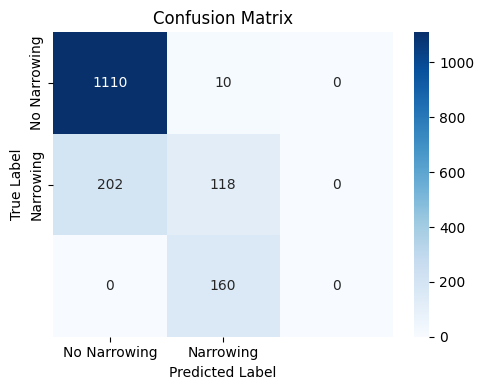

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# 📂 Load the data
df = pd.read_csv("/content/narrowing_detection_comparison.csv")  # Replace with actual filename

# 🧹 Map prediction_detail based on your rules
narrowing_labels = ['Moderate Narrowing', 'Severe Narrowing', 'Narrowing Present']
df['pred_binary'] = df['prediction_detail'].apply(lambda x: 1 if str(x).strip() in narrowing_labels else 0)
df['true_label'] = df['true_label'].astype(int)

# ✅ Evaluation
y_true = df['true_label']
y_pred = df['pred_binary']

print("\n🔍 Classification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

print(f"⭐ Macro F1-score:    {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
print(f"⭐ Weighted F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
print(f"⭐ Micro F1-score:    {f1_score(y_true, y_pred, average='micro', zero_division=0):.4f}")

# 🔳 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Narrowing', 'Narrowing'],
            yticklabels=['No Narrowing', 'Narrowing'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("binary_confusion_matrix.png")
plt.show()


In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import joblib

# 📂 Load your data
df = pd.read_csv("/content/narrowing_detection_comparison.csv")

# 🎯 Target and features
feature_cols = [
    'narrowing_ratio',
    'max_width_drop',
    'focal_narrowing_count',
    'vessel_density',
    'vessel_irregularity'
]
X = df[feature_cols]
y = df['true_label'].astype(int)

# 🧪 Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🧠 Train Logistic Regression model
clf = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# 📈 Evaluate
y_pred = clf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n🔳 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 💾 Save model
joblib.dump(clf, "narrowing_detection_model.pkl")
print("✅ Model saved as narrowing_detection_model.pkl")



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       224
           1       0.69      0.77      0.73        64
           2       0.77      0.84      0.81        32

    accuracy                           0.88       320
   macro avg       0.81      0.84      0.83       320
weighted avg       0.89      0.88      0.89       320


🔳 Confusion Matrix:
[[207  17   0]
 [  7  49   8]
 [  0   5  27]]
✅ Model saved as narrowing_detection_model.pkl


In [ ]:
import joblib
import numpy as np

# Load the saved model
clf = joblib.load("/content/narrowing_detection_model.pkl")

def classify_narrowing(features: np.ndarray):
    # features shape: (n_samples, n_features) or (1, n_features)
    prediction = clf.predict(features)[0]  # Get first prediction
    score = clf.predict_proba(features)[0, prediction]  # Probability of predicted class

    # Safety check
    if prediction not in [0, 1]:
        prediction = 1  # fallback safety

    stats = {
        "prediction_probabilities": clf.predict_proba(features)[0].tolist()
    }
    return prediction, score, stats


In [ ]:
import pandas as pd
import joblib

# 🔄 Load trained model
model = joblib.load("/content/narrowing_detection_model.pkl")  # Update path if needed

# 📂 Load your full dataset
df = pd.read_csv("/content/narrowing_detection_comparison.csv")

# 🔎 Features for prediction
feature_cols = [
    'narrowing_ratio',
    'max_width_drop',
    'focal_narrowing_count',
    'vessel_density',
    'vessel_irregularity'
]

X = df[feature_cols]

# 🔮 Predict using the model
df['predicted_label'] = model.predict(X)
df['predicted_proba'] = model.predict_proba(X)[:, 1]  # Probability of class '1' (narrowing)

# 📝 View predictions
print(df[['filename', 'predicted_label', 'predicted_proba']].head())

# 💾 Optional: Save to CSV
df.to_csv("/content/narrowing_predictions_output.csv", index=False)
print("✅ Predictions saved to narrowing_predictions_output.csv")


                 filename  predicted_label  predicted_proba
0  retinal_image_0000.jpg                0         0.020094
1  retinal_image_0001.jpg                0         0.031813
2  retinal_image_0002.jpg                0         0.026589
3  retinal_image_0003.jpg                0         0.225433
4  retinal_image_0004.jpg                0         0.112792
✅ Predictions saved to narrowing_predictions_output.csv


In [ ]:
import torch
import cv2
import numpy as np
import joblib
from PIL import Image
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# ===== Step 1: Load Image =====
img_path = "/content/STARE_DATA/im0211.ppm"  # ← Replace with your uploaded file path
image = Image.open(img_path).convert("RGB")
image = image.resize((512, 512))  # Resize to model input size
img_np = np.array(image)

# Normalize like training
img_tensor = torch.from_numpy(img_np.transpose(2, 0, 1)).float() / 255.0
img_tensor = (img_tensor - 0.5) / 0.5  # Assuming mean=0.5, std=0.5 used
img_tensor = img_tensor.unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

# ===== Step 2: Load Segmentation Model =====
#from your_model_file import ImprovedUNet  # Make sure this is defined above
model = ImprovedUNet().to(img_tensor.device)
model.load_state_dict(torch.load("/content/saved_models/best_vessel_segmentation_model_state_dict.pth", map_location=img_tensor.device))
model.eval()

with torch.no_grad():
    pred_mask = model(img_tensor)
    pred_mask = (pred_mask.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

# ===== Step 3: Feature Extraction =====
def extract_vessel_features(binary_mask):
    if np.sum(binary_mask) == 0:
        return {'narrowing_ratio': 0, 'focal_narrowing_count': 0, 'max_width_drop': 0}

    skeleton = skeletonize(binary_mask.astype(bool))
    distance = distance_transform_edt(binary_mask)
    widths = distance[skeleton] * 2

    if len(widths) < 10:
        return {'narrowing_ratio': 0, 'focal_narrowing_count': 0, 'max_width_drop': 0}

    smooth = gaussian_filter1d(widths, sigma=2)
    drop = (np.max(smooth) - np.min(smooth)) / (np.max(smooth) + 1e-6)
    peaks, _ = find_peaks(-smooth, height=-np.percentile(smooth, 25))
    narrowing_ratio = (drop > 0.5) * 1

    return {
        'narrowing_ratio': narrowing_ratio,
        'focal_narrowing_count': len(peaks),
        'max_width_drop': drop
    }

features = extract_vessel_features(pred_mask)

# Fill dummy values for vessel_density, vessel_irregularity (or compute them if needed)
features['vessel_density'] = np.sum(pred_mask) / (512 * 512)
features['vessel_irregularity'] = np.std(distance_transform_edt(pred_mask)) if np.sum(pred_mask) > 0 else 0

# ===== Step 4: Predict Using .pkl Classifier =====
clf = joblib.load("/content/narrowing_detection_model.pkl")
input_vector = [[
    features['narrowing_ratio'],
    features['max_width_drop'],
    features['focal_narrowing_count'],
    features['vessel_density'],
    features['vessel_irregularity']
]]

pred = clf.predict(input_vector)[0]
confidence = clf.predict_proba(input_vector)[0][1]

# ===== Step 5: Show Result =====
label = "Narrowing Detected ✅" if pred == 1 else "No Narrowing ❌"
print(f"\n🧠 Prediction: {label}")
print(f"📊 Confidence: {confidence:.2f}")



🧠 Prediction: Narrowing Detected ✅
📊 Confidence: 0.62


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [ ]:
import os
import torch
import cv2
import numpy as np
import joblib
from PIL import Image
import pandas as pd
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# ===== Define Feature Extraction Function =====
def extract_vessel_features(binary_mask):
    if np.sum(binary_mask) == 0:
        return {'narrowing_ratio': 0, 'focal_narrowing_count': 0, 'max_width_drop': 0}

    skeleton = skeletonize(binary_mask.astype(bool))
    distance = distance_transform_edt(binary_mask)
    widths = distance[skeleton] * 2

    if len(widths) < 10:
        return {'narrowing_ratio': 0, 'focal_narrowing_count': 0, 'max_width_drop': 0}

    smooth = gaussian_filter1d(widths, sigma=2)
    drop = (np.max(smooth) - np.min(smooth)) / (np.max(smooth) + 1e-6)
    peaks, _ = find_peaks(-smooth, height=-np.percentile(smooth, 25))
    narrowing_ratio = (drop > 0.5) * 1

    return {
        'narrowing_ratio': narrowing_ratio,
        'focal_narrowing_count': len(peaks),
        'max_width_drop': drop
    }

# ===== Load Classifier and Model =====
clf = joblib.load("/content/narrowing_detection_model.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedUNet().to(device)
model.load_state_dict(torch.load("/content/saved_models/best_vessel_segmentation_model_state_dict.pth", map_location=device))
model.eval()

# ===== Set Image Directory =====
test_dir = "/content/STARE_DATA"  # Change if needed
image_extensions = [".ppm", ".jpg", ".jpeg", ".png", ".tif"]
image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if os.path.splitext(f)[1].lower() in image_extensions]

# ===== Loop Over Images =====
results = []

for img_path in image_paths:
    try:
        # --- Load and preprocess image ---
        image = Image.open(img_path).convert("RGB").resize((512, 512))
        img_np = np.array(image)
        img_tensor = torch.from_numpy(img_np.transpose(2, 0, 1)).float() / 255.0
        img_tensor = (img_tensor - 0.5) / 0.5
        img_tensor = img_tensor.unsqueeze(0).to(device)

        # --- Predict vessel mask ---
        with torch.no_grad():
            pred_mask = model(img_tensor)
            pred_mask = (pred_mask.squeeze().cpu().numpy() > 0.5).astype(np.uint8)

        # --- Extract features ---
        features = extract_vessel_features(pred_mask)
        features['vessel_density'] = np.sum(pred_mask) / (512 * 512)
        features['vessel_irregularity'] = np.std(distance_transform_edt(pred_mask)) if np.sum(pred_mask) > 0 else 0

        # --- Classify narrowing ---
        input_vector = [[
            features['narrowing_ratio'],
            features['max_width_drop'],
            features['focal_narrowing_count'],
            features['vessel_density'],
            features['vessel_irregularity']
        ]]
        pred = clf.predict(input_vector)[0]
        confidence = clf.predict_proba(input_vector)[0][1]

        results.append({
            "filename": os.path.basename(img_path),
            "narrowing_detected": "Yes" if pred == 1 else "No",
            "confidence": round(confidence, 3),
            **features
        })
        print(f"✅ Processed {os.path.basename(img_path)}: {'Narrowing' if pred == 1 else 'No Narrowing'} ({confidence:.2f})")

    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {e}")

# ===== Save to CSV =====
output_df = pd.DataFrame(results)
output_path = "/content/narrowing_predictions_batch.csv"
output_df.to_csv(output_path, index=False)
print(f"\n📄 Saved predictions to: {output_path}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0309.ppm: No Narrowing (0.00)
✅ Processed im0324.ppm: No Narrowing (0.04)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0110.ppm: No Narrowing (0.00)
✅ Processed im0322.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0274.ppm: No Narrowing (0.00)
✅ Processed im0145.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0191.ppm: No Narrowing (0.00)
✅ Processed im0132.ppm: No Narrowing (0.05)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0288.ppm: No Narrowing (0.00)
✅ Processed im0061.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0019.ppm: No Narrowing (0.00)
✅ Processed im0041.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0374.ppm: No Narrowing (0.00)
✅ Processed im0122.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0114.ppm: No Narrowing (0.00)
✅ Processed im0124.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0139.ppm: No Narrowing (0.00)
✅ Processed im0193.ppm: No Narrowing (0.02)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0039.ppm: No Narrowing (0.00)
✅ Processed im0250.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0398.ppm: No Narrowing (0.00)
✅ Processed im0371.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0354.ppm: No Narrowing (0.00)
✅ Processed im0395.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0336.ppm: No Narrowing (0.00)
✅ Processed im0117.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0353.ppm: No Narrowing (0.00)
✅ Processed im0234.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0040.ppm: No Narrowing (0.00)
✅ Processed im0173.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0312.ppm: No Narrowing (0.00)
✅ Processed im0345.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist

✅ Processed im0302.ppm: No Narrowing (0.00)
✅ Processed im0260.ppm: No Narrowing (0.00)
✅ Processed im0329.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0299.ppm: No Narrowing (0.00)
✅ Processed im0335.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0185.ppm: No Narrowing (0.00)
✅ Processed im0391.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0292.ppm: No Narrowing (0.00)
✅ Processed im0397.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0202.ppm: No Narrowing (0.00)
✅ Processed im0001.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0074.ppm: No Narrowing (0.00)
✅ Processed im0251.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist

✅ Processed im0020.ppm: No Narrowing (0.00)
✅ Processed im0175.ppm: No Narrowing (0.00)
✅ Processed im0380.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0201.ppm: No Narrowing (0.00)
✅ Processed im0205.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0280.ppm: No Narrowing (0.00)
✅ Processed im0180.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0045.ppm: No Narrowing (0.00)
✅ Processed im0381.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0153.ppm: No Narrowing (0.00)
✅ Processed im0402.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0075.ppm: No Narrowing (0.00)
✅ Processed im0146.ppm: No Narrowing (0.03)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0200.ppm: No Narrowing (0.00)
✅ Processed im0244.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0328.ppm: No Narrowing (0.00)
✅ Processed im0035.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0044.ppm: No Narrowing (0.00)
✅ Processed im0165.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0102.ppm: No Narrowing (0.00)
✅ Processed im0104.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0148.ppm: No Narrowing (0.32)
✅ Processed im0346.ppm: No Narrowing (0.10)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0211.ppm: Narrowing (0.62)
✅ Processed im0069.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0303.ppm: No Narrowing (0.25)
✅ Processed im0327.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0263.ppm: No Narrowing (0.00)
✅ Processed im0025.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0012.ppm: No Narrowing (0.00)
✅ Processed im0150.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0217.ppm: No Narrowing (0.00)
✅ Processed im0229.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0283.ppm: No Narrowing (0.00)
✅ Processed im0057.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0196.ppm: No Narrowing (0.00)
✅ Processed im0158.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0401.ppm: No Narrowing (0.00)
✅ Processed im0212.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0098.ppm: No Narrowing (0.00)
✅ Processed im0372.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0115.ppm: No Narrowing (0.00)
✅ Processed im0079.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0056.ppm: No Narrowing (0.00)
✅ Processed im0269.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0131.ppm: No Narrowing (0.01)
✅ Processed im0100.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0009.ppm: No Narrowing (0.00)
✅ Processed im0021.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0121.ppm: No Narrowing (0.00)
✅ Processed im0223.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0065.ppm: No Narrowing (0.00)
✅ Processed im0089.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0179.ppm: No Narrowing (0.00)
✅ Processed im0097.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0232.ppm: No Narrowing (0.00)
✅ Processed im0278.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0002.ppm: No Narrowing (0.00)
✅ Processed im0394.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0090.ppm: No Narrowing (0.00)
✅ Processed im0339.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0026.ppm: No Narrowing (0.00)
✅ Processed im0342.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0066.ppm: No Narrowing (0.00)
✅ Processed im0143.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0376.ppm: No Narrowing (0.00)
✅ Processed im0287.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0295.ppm: No Narrowing (0.15)
✅ Processed im0106.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0253.ppm: No Narrowing (0.00)
✅ Processed im0314.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0162.ppm: No Narrowing (0.00)
✅ Processed im0042.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0032.ppm: No Narrowing (0.00)
✅ Processed im0259.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0083.ppm: No Narrowing (0.00)
✅ Processed im0241.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0033.ppm: No Narrowing (0.00)
✅ Processed im0311.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0306.ppm: No Narrowing (0.00)
✅ Processed im0007.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0320.ppm: Narrowing (0.89)
✅ Processed im0178.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0384.ppm: No Narrowing (0.00)
✅ Processed im0123.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0388.ppm: No Narrowing (0.00)
✅ Processed im0156.ppm: No Narrowing (0.01)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0147.ppm: No Narrowing (0.00)
✅ Processed im0386.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0197.ppm: No Narrowing (0.00)
✅ Processed im0393.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0267.ppm: No Narrowing (0.00)
✅ Processed im0188.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0350.ppm: No Narrowing (0.00)
✅ Processed im0068.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0198.ppm: No Narrowing (0.00)
✅ Processed im0204.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0264.ppm: No Narrowing (0.00)
✅ Processed im0170.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0004.ppm: No Narrowing (0.00)
✅ Processed im0266.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0043.ppm: No Narrowing (0.00)
✅ Processed im0256.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0273.ppm: No Narrowing (0.00)
✅ Processed im0282.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0029.ppm: No Narrowing (0.00)
✅ Processed im0248.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0092.ppm: No Narrowing (0.00)
✅ Processed im0221.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0281.ppm: No Narrowing (0.02)
✅ Processed im0151.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0361.ppm: No Narrowing (0.00)
✅ Processed im0003.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0254.ppm: No Narrowing (0.00)
✅ Processed im0152.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0017.ppm: No Narrowing (0.00)
✅ Processed im0183.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0082.ppm: No Narrowing (0.00)
✅ Processed im0181.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0344.ppm: No Narrowing (0.00)
✅ Processed im0099.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0383.ppm: No Narrowing (0.00)
✅ Processed im0059.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0062.ppm: No Narrowing (0.00)
✅ Processed im0271.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0290.ppm: No Narrowing (0.00)
✅ Processed im0113.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0237.ppm: No Narrowing (0.00)
✅ Processed im0084.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0203.ppm: No Narrowing (0.00)
✅ Processed im0008.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0125.ppm: No Narrowing (0.00)
✅ Processed im0284.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0246.ppm: No Narrowing (0.00)
✅ Processed im0357.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0058.ppm: No Narrowing (0.00)
✅ Processed im0080.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0023.ppm: No Narrowing (0.00)
✅ Processed im0078.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0366.ppm: No Narrowing (0.00)
✅ Processed im0226.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0307.ppm: No Narrowing (0.00)
✅ Processed im0238.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0233.ppm: No Narrowing (0.00)
✅ Processed im0094.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0293.ppm: No Narrowing (0.00)
✅ Processed im0184.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0313.ppm: No Narrowing (0.00)
✅ Processed im0076.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0387.ppm: No Narrowing (0.00)
✅ Processed im0390.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0192.ppm: No Narrowing (0.00)
✅ Processed im0163.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0356.ppm: No Narrowing (0.00)
✅ Processed im0341.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0036.ppm: No Narrowing (0.00)
✅ Processed im0101.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0060.ppm: No Narrowing (0.00)
✅ Processed im0279.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0298.ppm: No Narrowing (0.00)
✅ Processed im0231.ppm: Narrowing (0.75)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0363.ppm: No Narrowing (0.00)
✅ Processed im0142.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0318.ppm: No Narrowing (0.00)
✅ Processed im0258.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0255.ppm: No Narrowing (0.00)
✅ Processed im0239.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0362.ppm: No Narrowing (0.00)
✅ Processed im0149.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0242.ppm: No Narrowing (0.00)
✅ Processed im0177.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0385.ppm: No Narrowing (0.00)
✅ Processed im0325.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0331.ppm: No Narrowing (0.00)
✅ Processed im0305.ppm: No Narrowing (0.30)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0219.ppm: No Narrowing (0.00)
✅ Processed im0086.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0022.ppm: No Narrowing (0.00)
✅ Processed im0037.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0154.ppm: No Narrowing (0.00)
✅ Processed im0315.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0375.ppm: No Narrowing (0.00)
✅ Processed im0216.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0319.ppm: No Narrowing (0.01)
✅ Processed im0031.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0399.ppm: No Narrowing (0.00)
✅ Processed im0227.ppm: Narrowing (0.79)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0116.ppm: No Narrowing (0.00)
✅ Processed im0159.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0013.ppm: No Narrowing (0.00)
✅ Processed im0355.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0085.ppm: No Narrowing (0.00)
✅ Processed im0224.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0268.ppm: No Narrowing (0.00)
✅ Processed im0389.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0135.ppm: No Narrowing (0.00)
✅ Processed im0182.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0160.ppm: No Narrowing (0.00)
✅ Processed im0053.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0027.ppm: No Narrowing (0.00)
✅ Processed im0107.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0210.ppm: No Narrowing (0.00)
✅ Processed im0015.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0136.ppm: No Narrowing (0.00)
✅ Processed im0071.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0070.ppm: No Narrowing (0.00)
✅ Processed im0275.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0337.ppm: No Narrowing (0.01)
✅ Processed im0127.ppm: No Narrowing (0.03)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0358.ppm: No Narrowing (0.00)
✅ Processed im0195.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0249.ppm: No Narrowing (0.00)
✅ Processed im0077.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0215.ppm: No Narrowing (0.00)
✅ Processed im0137.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0262.ppm: No Narrowing (0.00)
✅ Processed im0343.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0252.ppm: No Narrowing (0.00)
✅ Processed im0050.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0018.ppm: No Narrowing (0.00)
✅ Processed im0118.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0347.ppm: No Narrowing (0.00)
✅ Processed im0304.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0291.ppm: No Narrowing (0.00)
✅ Processed im0028.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0240.ppm: No Narrowing (0.00)
✅ Processed im0272.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0005.ppm: No Narrowing (0.00)
✅ Processed im0048.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0316.ppm: No Narrowing (0.00)
✅ Processed im0308.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0105.ppm: No Narrowing (0.00)
✅ Processed im0103.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0321.ppm: No Narrowing (0.00)
✅ Processed im0323.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0296.ppm: No Narrowing (0.00)
✅ Processed im0112.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0222.ppm: No Narrowing (0.00)
✅ Processed im0049.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0369.ppm: No Narrowing (0.00)
✅ Processed im0209.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0265.ppm: No Narrowing (0.00)
✅ Processed im0365.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0055.ppm: No Narrowing (0.00)
✅ Processed im0169.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0016.ppm: No Narrowing (0.00)
✅ Processed im0392.ppm: No Narrowing (0.03)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0161.ppm: No Narrowing (0.00)
✅ Processed im0285.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0052.ppm: No Narrowing (0.00)
✅ Processed im0206.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0011.ppm: No Narrowing (0.00)
✅ Processed im0095.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0243.ppm: No Narrowing (0.00)
✅ Processed im0289.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0024.ppm: No Narrowing (0.00)
✅ Processed im0370.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0054.ppm: No Narrowing (0.00)
✅ Processed im0038.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0120.ppm: No Narrowing (0.00)
✅ Processed im0310.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0164.ppm: No Narrowing (0.05)
✅ Processed im0400.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0030.ppm: No Narrowing (0.00)
✅ Processed im0051.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0166.ppm: No Narrowing (0.00)
✅ Processed im0326.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0364.ppm: No Narrowing (0.00)
✅ Processed im0128.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0330.ppm: No Narrowing (0.00)
✅ Processed im0340.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0294.ppm: No Narrowing (0.00)
✅ Processed im0317.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0349.ppm: No Narrowing (0.00)
✅ Processed im0091.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0225.ppm: No Narrowing (0.00)
✅ Processed im0368.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0119.ppm: No Narrowing (0.00)
✅ Processed im0261.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0230.ppm: No Narrowing (0.00)
✅ Processed im0155.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0187.ppm: No Narrowing (0.00)
✅ Processed im0286.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0081.ppm: No Narrowing (0.00)
✅ Processed im0141.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0333.ppm: No Narrowing (0.00)
✅ Processed im0297.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0190.ppm: No Narrowing (0.00)
✅ Processed im0088.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0186.ppm: No Narrowing (0.00)
✅ Processed im0010.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0046.ppm: Narrowing (0.62)
✅ Processed im0176.ppm: No Narrowing (0.01)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0064.ppm: No Narrowing (0.00)
✅ Processed im0073.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0359.ppm: No Narrowing (0.00)
✅ Processed im0213.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0382.ppm: No Narrowing (0.00)
✅ Processed im0063.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0126.ppm: No Narrowing (0.00)
✅ Processed im0014.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0334.ppm: No Narrowing (0.00)
✅ Processed im0270.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0133.ppm: No Narrowing (0.00)
✅ Processed im0236.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0171.ppm: No Narrowing (0.00)
✅ Processed im0338.ppm: No Narrowing (0.04)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0218.ppm: No Narrowing (0.00)
✅ Processed im0214.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0006.ppm: No Narrowing (0.00)
✅ Processed im0247.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0034.ppm: No Narrowing (0.00)
✅ Processed im0129.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0168.ppm: No Narrowing (0.00)
✅ Processed im0067.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0189.ppm: No Narrowing (0.00)
✅ Processed im0301.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0208.ppm: No Narrowing (0.00)
✅ Processed im0360.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist

✅ Processed im0174.ppm: No Narrowing (0.00)
✅ Processed im0367.ppm: No Narrowing (0.00)
✅ Processed im0276.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0300.ppm: No Narrowing (0.00)
✅ Processed im0096.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0378.ppm: No Narrowing (0.00)
✅ Processed im0207.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0396.ppm: No Narrowing (0.00)
✅ Processed im0348.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0220.ppm: No Narrowing (0.00)
✅ Processed im0093.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0134.ppm: No Narrowing (0.00)
✅ Processed im0199.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0130.ppm: No Narrowing (0.00)
✅ Processed im0352.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0245.ppm: No Narrowing (0.00)
✅ Processed im0140.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0379.ppm: No Narrowing (0.02)
✅ Processed im0087.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0138.ppm: No Narrowing (0.00)
✅ Processed im0257.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0373.ppm: No Narrowing (0.00)
✅ Processed im0111.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0228.ppm: No Narrowing (0.00)
✅ Processed im0072.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0351.ppm: No Narrowing (0.00)
✅ Processed im0194.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0157.ppm: No Narrowing (0.00)
✅ Processed im0277.ppm: No Narrowing (0.00)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


✅ Processed im0172.ppm: No Narrowing (0.00)
✅ Processed im0332.ppm: No Narrowing (0.00)
✅ Processed im0377.ppm: No Narrowing (0.00)
✅ Processed im0235.ppm: No Narrowing (0.00)

📄 Saved predictions to: /content/narrowing_predictions_batch.csv


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
